# Entropy Analysis - ALL
Takes data generated from `../src/extraction_llama.py` and performs entropy analysis experiments

In [1]:
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from scipy.stats import entropy, ttest_ind, spearmanr, normaltest, ttest_1samp, kruskal
from tqdm import tqdm
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Data Config
DATA_DIR = "../data/chunk_0_299_output/attention"
PREPARED_DATA_DIR = "../data/prepared_data_individual"
ENTROPY_RESULTS_DIR = "../data/entropy_results_dirs"
RESULTS_CSV = "../data/chunks/results_llama.csv"
TOKEN_METADATA = "../data/chunk_0_299_output/token_metadata_llama.json"
AGGREGATED_ANALYSIS_DIR = "../data/aggregated_analysis_combined"  # Contains individual phrase aggregation files
STATISTICAL_RESULTS_DIR = "../data/statistical_results_combined"  # Contains individual phrase statistical analysis files
VISUAL_RESULTS_DIR = "../figures/visualizations_individual_combined"

## Prepare attention data

In [3]:
class AttentionDataPreparationIndividual:
    def __init__(self, data_dir: str, results_csv: str, token_metadata_json: str):
        """
        Prepare Data: Load attention files, normalize rows, identify individual phrase positions (6 + 1)

        Args:
            data_dir: Base directory containing row_X/prompt_Y/attn_layer_Z.npy structure
            results_csv: Path to results CSV file
            token_metadata_json: Path to token metadata JSON file
        """
        self.data_dir = data_dir
        self.attention_dir = data_dir

        # Load dataset and metadata
        self.results_df = pd.read_csv(results_csv)
        with open(token_metadata_json, 'r') as f:
            self.token_metadata = json.load(f)

        # Define individual bias phrases (6 + 1 combined)
        self.individual_bias_phrases = ["teacher", "own", "sure", "unsure", "quick", "fast", "step"]
        self.analysis_keys = self.individual_bias_phrases + ["combined"]

        # Storage for processed data
        self.normalized_attention = {}
        self.hint_positions_individual = {}  # {phrase: {row_prompt: positions}}
        self.validation_log = []

        # Prompt mapping for file system
        self.prompt_mapping = {
            'Prompt_1': 'prompt_1',
            'Prompt_2': 'prompt_2',
            'Prompt_3': 'prompt_3'
        }

        # Initialize storage for each phrase analysis
        for phrase in self.analysis_keys:
            self.hint_positions_individual[phrase] = {}

        print(f"Loaded {len(self.results_df)} rows from dataset")
        print(f"Loaded token metadata for {len(self.token_metadata)} rows")
        print(f"Individual phrase analyses: {', '.join(self.individual_bias_phrases)}")
        print(f"Total analyses: {len(self.analysis_keys)} (6 individual + 1 combined)")

    def validate_data_structure(self) -> Dict[str, int]:
        """Validate the attention data structure and count available files"""
        print("Validating data structure...")

        validation_stats = {
            'total_rows_checked': 0,
            'rows_with_attention_data': 0,
            'total_attention_files': 0,
            'missing_files': 0,
            'invalid_files': 0
        }

        max_check = min(10, len(self.results_df))

        for row_idx in range(max_check):
            validation_stats['total_rows_checked'] += 1
            row_has_data = False

            for prompt_col in ['Prompt_1', 'Prompt_2', 'Prompt_3']:
                if pd.isna(self.results_df.iloc[row_idx][prompt_col]):
                    continue

                prompt_file_name = self.prompt_mapping[prompt_col]
                row_dir = os.path.join(self.attention_dir, f"row_{row_idx}", prompt_file_name)

                if os.path.exists(row_dir):
                    npy_files = [f for f in os.listdir(row_dir) if f.endswith('.npy') and 'attn_layer_' in f]

                    for npy_file in npy_files:
                        file_path = os.path.join(row_dir, npy_file)
                        try:
                            test_load = np.load(file_path)
                            if len(test_load.shape) == 4:
                                validation_stats['total_attention_files'] += 1
                                row_has_data = True
                            else:
                                self.validation_log.append(f"Invalid shape {test_load.shape} in {file_path}")
                                validation_stats['invalid_files'] += 1
                        except Exception as e:
                            self.validation_log.append(f"Cannot load {file_path}: {e}")
                            validation_stats['invalid_files'] += 1
                else:
                    validation_stats['missing_files'] += 1

            if row_has_data:
                validation_stats['rows_with_attention_data'] += 1

        print(f"Checked {validation_stats['total_rows_checked']} rows")
        print(f"Found {validation_stats['total_attention_files']} valid attention files")

        return validation_stats

    def load_and_normalize_attention(self, row_idx: int, prompt_name: str, layer_idx: int) -> Optional[np.ndarray]:
        """
        Load attention weights and normalize rows to ensure each row sums to 1

        Args:
            row_idx: Row index in dataset
            prompt_name: Prompt file name (prompt_1, prompt_2, prompt_3)
            layer_idx: Layer index (0 to num_layers-1)

        Returns:
            Normalized attention matrix [batch, heads, seq_len, seq_len] or None
        """
        file_path = os.path.join(
            self.attention_dir,
            f"row_{row_idx}",
            prompt_name,
            f"attn_layer_{layer_idx}.npy"
        )

        if not os.path.exists(file_path):
            return None

        try:
            attention = np.load(file_path)

            if len(attention.shape) != 4:
                self.validation_log.append(f"Invalid shape {attention.shape} in {file_path}")
                return None

            batch_size, num_heads, seq_len, key_len = attention.shape
            normalized_attention = attention.copy()

            # Normalize rows to ensure each query's attention sums to 1
            normalization_fixes = 0
            for b in range(batch_size):
                for h in range(num_heads):
                    for q in range(seq_len):
                        attn_row = attention[b, h, q, :]
                        row_sum = np.sum(attn_row)

                        if not (0.99 <= row_sum <= 1.01):
                            if row_sum > 0 and not np.isnan(row_sum):
                                normalized_attention[b, h, q, :] = attn_row / row_sum
                                normalization_fixes += 1
                            else:
                                normalized_attention[b, h, q, :] = np.ones(key_len) / key_len
                                normalization_fixes += 1

            return normalized_attention

        except Exception as e:
            self.validation_log.append(f"Error processing {file_path}: {e}")
            return None

    def identify_hint_positions_individual(self, row_idx: int, prompt_col: str) -> Dict[str, List[int]]:
        """
        Identify hint positions for each individual bias phrase + combined

        Args:
            row_idx: Row index in dataset
            prompt_col: Prompt column name (Prompt_1, Prompt_2, Prompt_3)

        Returns:
            Dict mapping phrase -> list of token positions
            Plus 'combined' key with all positions
        """
        try:
            # Access token metadata
            if isinstance(self.token_metadata, list):
                if row_idx < len(self.token_metadata):
                    row_metadata = self.token_metadata[row_idx]
                else:
                    return {phrase: [] for phrase in self.analysis_keys}
            else:
                if str(row_idx) in self.token_metadata:
                    row_metadata = self.token_metadata[str(row_idx)]
                elif row_idx in self.token_metadata:
                    row_metadata = self.token_metadata[row_idx]
                else:
                    return {phrase: [] for phrase in self.analysis_keys}

            # Extract input tokens
            if isinstance(row_metadata, dict) and prompt_col in row_metadata:
                prompt_metadata = row_metadata[prompt_col]
                input_tokens = prompt_metadata.get('input_tokens', [])
            elif isinstance(row_metadata, dict) and 'input_tokens' in row_metadata:
                input_tokens = row_metadata.get('input_tokens', [])
            else:
                return {phrase: [] for phrase in self.analysis_keys}

            # Find positions for each individual phrase
            phrase_positions = {}
            all_combined_positions = []

            for phrase in self.individual_bias_phrases:
                phrase_specific_positions = []

                for i, token in enumerate(input_tokens):
                    clean_token = str(token).replace('Ġ', '').replace('▁', '').replace('##', '').lower().strip()

                    if phrase in clean_token:
                        phrase_specific_positions.append(i)
                        all_combined_positions.append(i)

                phrase_positions[phrase] = sorted(list(set(phrase_specific_positions)))

            # Add combined positions
            phrase_positions['combined'] = sorted(list(set(all_combined_positions)))

            return phrase_positions

        except (KeyError, TypeError, AttributeError, IndexError) as e:
            self.validation_log.append(f"Error finding individual hints for row {row_idx}, {prompt_col}: {e}")
            return {phrase: [] for phrase in self.analysis_keys}

    def process_all_attention_data_individual(self, max_rows: int = None) -> Dict:
        """
        Process all attention data: load, normalize, and identify individual phrase positions

        Args:
            max_rows: Maximum number of rows to process (None for all)

        Returns:
            Dictionary with processing statistics
        """
        print("Processing attention data with individual phrase analysis...")
        print(f"Analyzing {len(self.individual_bias_phrases)} individual phrases + 1 combined analysis")

        if max_rows is None:
            max_rows = len(self.results_df)

        num_layers = self._detect_num_layers()
        print(f"Detected {num_layers} layers in the model")

        processing_stats = {
            'total_rows_processed': 0,
            'total_prompts_processed': 0,
            'total_attention_matrices_loaded': 0,
            'phrases_processed': {phrase: 0 for phrase in self.analysis_keys},
            'rows_with_errors': 0
        }

        for row_idx in tqdm(range(min(max_rows, len(self.results_df))),
                            desc="Processing rows",
                            leave=False):
        # for row_idx in range(min(max_rows, len(self.results_df))):
            row_has_errors = False
            self.normalized_attention[row_idx] = {}

            for prompt_col in ['Prompt_1', 'Prompt_2', 'Prompt_3']:
                if pd.isna(self.results_df.iloc[row_idx][prompt_col]):
                    continue

                processing_stats['total_prompts_processed'] += 1
                prompt_file_name = self.prompt_mapping[prompt_col]

                # Get individual phrase positions
                phrase_positions = self.identify_hint_positions_individual(row_idx, prompt_col)

                # Store positions for each individual phrase + combined
                for phrase, positions in phrase_positions.items():
                    key = f"{row_idx}_{prompt_col}"
                    self.hint_positions_individual[phrase][key] = positions

                    if positions:
                        processing_stats['phrases_processed'][phrase] += len(positions)

                # Load and normalize attention for each layer
                for layer_idx in range(num_layers):
                    normalized_attn = self.load_and_normalize_attention(row_idx, prompt_file_name, layer_idx)

                    if normalized_attn is not None:
                        key = f"{prompt_col}_layer_{layer_idx}"
                        self.normalized_attention[row_idx][key] = normalized_attn
                        processing_stats['total_attention_matrices_loaded'] += 1
                    else:
                        row_has_errors = True

            if row_has_errors:
                processing_stats['rows_with_errors'] += 1

            processing_stats['total_rows_processed'] += 1

            # if (row_idx + 1) % 50 == 0:
            #     print(f"Processed {row_idx + 1} rows...")

        print(f"Processing complete: {processing_stats['total_rows_processed']} rows processed")
        print("Individual phrase statistics:")
        for phrase, count in processing_stats['phrases_processed'].items():
            print(f"  {phrase}: {count} positions found")

        return processing_stats

    def _detect_num_layers(self) -> int:
        """Auto-detect number of layers by checking available files"""
        for row_idx in range(min(5, len(self.results_df))):
            for prompt_name in ['prompt_1', 'prompt_2', 'prompt_3']:
                row_dir = os.path.join(self.attention_dir, f"row_{row_idx}", prompt_name)
                if os.path.exists(row_dir):
                    files = [f for f in os.listdir(row_dir) if f.startswith('attn_layer_') and f.endswith('.npy')]
                    if files:
                        layer_numbers = []
                        for f in files:
                            try:
                                layer_num = int(f.replace('attn_layer_', '').replace('.npy', ''))
                                layer_numbers.append(layer_num)
                            except:
                                continue
                        if layer_numbers:
                            return max(layer_numbers) + 1

        return 16  # Default based on diagnostics

    def save_results(self, output_dir: str = "../data/prepared_data_individual"):
        """Save results for use in subsequent processing steps"""
        print(f"Saving individual phrase results to {output_dir}/")

        os.makedirs(output_dir, exist_ok=True)

        # Save individual phrase positions
        for phrase in self.analysis_keys:
            phrase_file = os.path.join(output_dir, f"hint_positions_{phrase}.json")
            with open(phrase_file, 'w') as f:
                json.dump(self.hint_positions_individual[phrase], f, indent=2)

        # Save validation log if exists
        if self.validation_log:
            log_file = os.path.join(output_dir, "validation_log.txt")
            with open(log_file, 'w') as f:
                for log_entry in self.validation_log:
                    f.write(log_entry + "\n")

        # Save summary statistics
        summary = {
            'total_rows_in_dataset': len(self.results_df),
            'rows_with_normalized_attention': len(self.normalized_attention),
            'individual_phrases_analyzed': self.individual_bias_phrases,
            'analysis_types': {
                'individual_phrases': len(self.individual_bias_phrases),
                'combined_analysis': 1,
                'total_analyses': len(self.analysis_keys)
            },
            'phrase_position_counts': {
                phrase: len(positions_dict)
                for phrase, positions_dict in self.hint_positions_individual.items()
            },
            'total_validation_issues': len(self.validation_log),
            'prompt_mapping': self.prompt_mapping
        }

        summary_file = os.path.join(output_dir, "preparation_summary_individual.json")
        with open(summary_file, 'w') as f:
            json.dump(summary, f, indent=2)

        print("Individual phrase data preparation completed successfully!")
        print(f"Generated {len(self.individual_bias_phrases)} individual + 1 combined = {len(self.analysis_keys)} total analyses")
        print(f"Files generated:")
        for phrase in self.analysis_keys:
            print(f"  - hint_positions_{phrase}.json")

        return output_dir


def run_data_preparation_individual():
    """
    Run the complete data preparation pipeline for individual phrases
    """
    # Configuration - Update these paths for your setup
    # DATA_DIR = "../Test_output_10rows/input_attention"
    # TOKEN_METADATA = "/content/Test_output_10rows/input_attention_metadata.json"
    # RESULTS_CSV = "/content/Test_output_10rows/results_with_predictions.csv"

    print("Starting Individual Phrase Data Preparation")
    print("=" * 60)

    # Initialize data preparation
    processor = AttentionDataPreparationIndividual(
        data_dir=DATA_DIR,
        results_csv=RESULTS_CSV,
        token_metadata_json=TOKEN_METADATA
    )

    # Validate data structure
    validation_stats = processor.validate_data_structure()

    # Process all data
    processing_stats = processor.process_all_attention_data_individual()

    # Save results for next stage
    output_dir = processor.save_results(PREPARED_DATA_DIR)

    print(f"\nIndividual phrase data preparation completed: {output_dir}")
    print("Ready for individual phrase entropy computation")

    return processor, processing_stats


if __name__ == "__main__":
    processor, stats = run_data_preparation_individual()

Starting Individual Phrase Data Preparation
Loaded 300 rows from dataset
Loaded token metadata for 300 rows
Individual phrase analyses: teacher, own, sure, unsure, quick, fast, step
Total analyses: 8 (6 individual + 1 combined)
Validating data structure...
Checked 10 rows
Found 416 valid attention files
Processing attention data with individual phrase analysis...
Analyzing 7 individual phrases + 1 combined analysis
Detected 16 layers in the model


Processing complete: 300 rows processed
Individual phrase statistics:
  teacher: 167 positions found
  own: 205 positions found
  sure: 384 positions found
  unsure: 129 positions found
  quick: 129 positions found
  fast: 129 positions found
  step: 252 positions found
  combined: 1266 positions found
Saving individual phrase results to ../data/prepared_data_individual_300_599/
Individual phrase data preparation completed successfully!
Generated 7 individual + 1 combined = 8 total analyses
Files generated:
  - hint_positions_teacher.json
  - hint_positions_own.json
  - hint_positions_sure.json
  - hint_positions_unsure.json
  - hint_positions_quick.json
  - hint_positions_fast.json
  - hint_positions_step.json
  - hint_positions_combined.json

Individual phrase data preparation completed: ../data/prepared_data_individual_300_599
Ready for individual phrase entropy computation


## Compute Entropy

In [3]:
class EntropyComputationIndividual:
    def __init__(self, prepared_data_dir: str, data_dir: str):
        """
        Compute Entropy: Granular computation per query/head/layer for individual phrases (6 + 1)

        Formula: H_i^(ℓ,h) = -∑_j A_ij log(A_ij)

        Args:
            prepared_data_dir: Directory containing individual phrase hint_positions files
            data_dir: Base directory containing attention files
        """
        self.prepared_data_dir = prepared_data_dir
        self.data_dir = data_dir

        # Define analysis keys (6 individual + 1 combined)
        self.analysis_keys = ["teacher", "own", "sure", "unsure", "quick", "fast", "step", "combined"]

        # Load individual phrase positions from data preparation stage
        self.hint_positions_individual = {}
        for phrase in self.analysis_keys:
            phrase_file = os.path.join(prepared_data_dir, f"hint_positions_{phrase}.json")
            if os.path.exists(phrase_file):
                with open(phrase_file, 'r') as f:
                    self.hint_positions_individual[phrase] = json.load(f)
                print(f"Loaded hint positions for '{phrase}': {len(self.hint_positions_individual[phrase])} prompt instances")
            else:
                print(f"Warning: {phrase_file} not found")
                self.hint_positions_individual[phrase] = {}

        print(f"Loaded hint positions for {len(self.hint_positions_individual)} individual phrase analyses")

        # Storage for entropy results
        self.entropies = {}  # {row_prompt: entropies[ℓ][h][i] array} - same for all analyses
        self.hint_entropies_individual = {}  # {phrase: {row_prompt: [entropies[ℓ][h][pos] for pos in phrase_positions]}}

        # Initialize individual phrase storage
        for phrase in self.analysis_keys:
            self.hint_entropies_individual[phrase] = {}


    def compute_attention_entropy(self, attention_matrix: np.ndarray, hint_positions: List[int] = None) -> Dict:
        """
        Compute entropy for attention matrix using the specified formula

        Args:
            attention_matrix: Shape [batch, heads, seq_len, seq_len]
            hint_positions: List of hint token positions for subsetting

        Returns:
            Dictionary with entropies and hint_entropies
        """
        if len(attention_matrix.shape) != 4:
            return None

        # print(f"DEBUG: attention_matrix shape: {attention_matrix.shape}")
        # print(f"DEBUG: First row, head 0: {attention_matrix[0, 0, 0, :10]}")
        # print(f"DEBUG: Middle row, head 0: {attention_matrix[0, 0, attention_matrix.shape[2]//2, :10]}")
        # print(f"DEBUG: Last row, head 0: {attention_matrix[0, 0, -1, :10]}")
        # print(f"DEBUG: Same position, different heads: {attention_matrix[0, :5, 10, 0]}")  # Same query pos, different heads
        
        
        batch_size, num_heads, seq_len, key_len = attention_matrix.shape

        # Store entropies in [heads, seq_len] format
        entropies = np.zeros((num_heads, seq_len))

        # Loop over heads, then queries - exact methodology
        for h in range(num_heads):
            for i in range(seq_len):  # query token i
                # Get attention row for query i in head h
                attn_row = attention_matrix[0, h, i, :]  # Assuming batch_size=1

                # Formula: H_i^(ℓ,h) = -∑_j A_ij log(A_ij)
                ent = entropy(attn_row, base=2)

                # Handle edge cases
                if np.isnan(ent) or np.isinf(ent):
                    ent = 0.0

                entropies[h, i] = ent

        # Subset for hints
        hint_entropies = []
        if hint_positions:
            for h in range(num_heads):
                for pos in hint_positions:
                    if pos < seq_len:
                        hint_entropies.append(entropies[h, pos])

        return {
            'entropies': entropies,
            'hint_entropies': hint_entropies,
            'num_heads': num_heads,
            'seq_len': seq_len,
            'hint_positions': hint_positions or []
        }


    def compute_entropy_for_dataset_individual(self, max_rows: int = None):
        """
        Process entropy computation for the entire dataset with individual phrase analysis

        Args:
            max_rows: Maximum number of rows to process (None for all)
        """
        print("Computing entropy for dataset with individual phrase analysis...")
        print("Formula: H_i^(ℓ,h) = -∑_j A_ij log(A_ij)")
        print(f"Analyzing: {', '.join(self.analysis_keys)}")

        # Get available rows
        available_rows = []
        for item in os.listdir(self.data_dir):
            if item.startswith('row_') and os.path.isdir(os.path.join(self.data_dir, item)):
                try:
                    row_num = int(item.replace('row_', ''))
                    available_rows.append(row_num)
                except:
                    continue

        available_rows = sorted(available_rows)
        if max_rows:
            available_rows = available_rows[:max_rows]

        print(f"Processing {len(available_rows)} rows")

        total_entropy_values = 0
        total_matrices = 0

        # Process each row
        for row_idx in tqdm(available_rows, desc='processing rows', leave=False):
            # Process each prompt
            for prompt_name in ['prompt_1', 'prompt_2', 'prompt_3']:
                prompt_dir = os.path.join(self.data_dir, f"row_{row_idx}", prompt_name)
                if not os.path.exists(prompt_dir):
                    continue

                # Get individual phrase hint positions
                row_prompt_key = f"row_{row_idx}_{prompt_name}"
                phrase_hint_positions = {}

                for phrase in self.analysis_keys:
                    key = f"{row_idx}_Prompt_{prompt_name.split('_')[1]}"
                    phrase_hint_positions[phrase] = self.hint_positions_individual[phrase].get(key, [])

                # Get available layers
                layer_files = [f for f in os.listdir(prompt_dir) if f.startswith('attn_layer_') and f.endswith('.npy')]
                layer_indices = sorted([int(f.replace('attn_layer_', '').replace('.npy', '')) for f in layer_files])

                if not layer_indices:
                    continue

                # Load first matrix to get dimensions
                first_file = os.path.join(prompt_dir, f"attn_layer_{layer_indices[0]}.npy")
                sample_matrix = np.load(first_file)
                _, num_heads, seq_len, _ = sample_matrix.shape
                num_layers = len(layer_indices)

                # Initialize entropies[ℓ][h][i] array for this row_prompt
                entropies = np.zeros((num_layers, num_heads, seq_len))

                # Process each layer ℓ
                for layer_position, layer_idx in enumerate(layer_indices):
                    file_path = os.path.join(prompt_dir, f"attn_layer_{layer_idx}.npy")

                    try:
                        attention_matrix = np.load(file_path)

                        # Compute entropy
                        entropy_result = self.compute_attention_entropy(attention_matrix)

                        if entropy_result:
                            layer_entropies = entropy_result['entropies']  # [heads, seq_len]

                            # Store in entropies[ℓ][h][i] format
                            entropies[layer_position, :, :] = layer_entropies

                            total_matrices += 1
                            total_entropy_values += layer_entropies.size

                    except Exception as e:
                        print(f"Error processing layer {layer_idx}: {e}")

                # Store the complete entropies[ℓ][h][i] array (same for all analyses)
                self.entropies[row_prompt_key] = entropies

                # Extract individual phrase-specific entropies
                for phrase, hint_positions in phrase_hint_positions.items():
                    phrase_entropy_values = []

                    if hint_positions:
                        for layer_pos in range(num_layers):
                            for head_idx in range(num_heads):
                                for pos in hint_positions:
                                    if pos < seq_len:
                                        phrase_entropy_values.append(entropies[layer_pos, head_idx, pos])

                    self.hint_entropies_individual[phrase][row_prompt_key] = phrase_entropy_values

            # if (row_idx + 1) % 25 == 0:
            #     print(f"Processed {row_idx + 1} rows...")

        print(f"Individual phrase entropy computation complete!")
        print(f"Processed {total_matrices} attention matrices")
        print(f"Computed {total_entropy_values} entropy values")

        # Print summary for each phrase
        print("\nPhrase-specific entropy summary:")
        for phrase in self.analysis_keys:
            total_values = sum(len(values) for values in self.hint_entropies_individual[phrase].values())
            non_empty_instances = sum(1 for values in self.hint_entropies_individual[phrase].values() if len(values) > 0)
            print(f"  {phrase}: {total_values} entropy values, {non_empty_instances} instances with data")

        return {
            'total_matrices': total_matrices,
            'total_entropy_values': total_entropy_values,
            'rows_processed': len(available_rows),
            'phrase_analyses': len(self.analysis_keys)
        }


    def save_results(self, output_dir: str = ENTROPY_RESULTS_DIR):
        """
        Save individual phrase entropy computation results

        Output format: entropies[ℓ][h][i] arrays with individual phrase subsets
        """
        print(f"Saving individual phrase entropy results to {output_dir}/")
        os.makedirs(output_dir, exist_ok=True)

        # Convert numpy arrays to lists for JSON serialization
        entropies_for_json = {}
        for key, entropy_array in self.entropies.items():
            entropies_for_json[key] = entropy_array.tolist()

        # Save complete entropies[ℓ][h][i] arrays (same for all analyses)
        entropy_file = os.path.join(output_dir, "entropies_arrays.json")
        with open(entropy_file, 'w') as f:
            json.dump(entropies_for_json, f, indent=2)

        # Save individual phrase hint entropies
        for phrase in self.analysis_keys:
            phrase_file = os.path.join(output_dir, f"hint_entropies_{phrase}.json")
            with open(phrase_file, 'w') as f:
                json.dump(self.hint_entropies_individual[phrase], f, indent=2)

        # Save individual phrase hint positions for reference
        for phrase in self.analysis_keys:
            positions_file = os.path.join(output_dir, f"hint_positions_{phrase}.json")
            with open(positions_file, 'w') as f:
                json.dump(self.hint_positions_individual[phrase], f, indent=2)

        # Create comprehensive summary
        summary = {
            'methodology': 'H_i^(ℓ,h) = -∑_j A_ij log(A_ij)',
            'analysis_structure': {
                'individual_phrases': ["teacher", "own", "sure", "unsure", "quick", "fast", "step"],
                'combined_analysis': "combined (all phrases together)",
                'total_analyses': len(self.analysis_keys)
            },
            'storage_format': {
                'entropies': 'entropies[ℓ][h][i] arrays (layer, head, query)',
                'hint_entropies': 'phrase-specific: [entropies[ℓ][h][pos] for pos in phrase_positions]'
            },
            'phrase_statistics': {},
            'total_prompt_instances': len(self.entropies),
            'arrays_saved': list(self.entropies.keys())
        }

        # Add phrase statistics
        for phrase in self.analysis_keys:
            phrase_data = self.hint_entropies_individual[phrase]
            total_entropy_values = sum(len(values) for values in phrase_data.values())
            non_empty_instances = sum(1 for values in phrase_data.values() if len(values) > 0)

            summary['phrase_statistics'][phrase] = {
                'total_entropy_values': total_entropy_values,
                'prompt_instances_with_phrase': non_empty_instances,
                'total_prompt_instances': len(phrase_data),
                'coverage_percentage': (non_empty_instances / len(phrase_data)) * 100 if len(phrase_data) > 0 else 0
            }

        summary_file = os.path.join(output_dir, "entropy_summary_individual.json")
        with open(summary_file, 'w') as f:
            json.dump(summary, f, indent=2)

        print("Individual phrase entropy computation completed successfully!")
        print(f"Generated analyses for: {', '.join(self.analysis_keys)}")
        print("Files generated:")
        for phrase in self.analysis_keys:
            print(f"  - hint_entropies_{phrase}.json")
            print(f"  - hint_positions_{phrase}.json")
        print("Ready for individual phrase aggregation analysis")

        return output_dir


def run_entropy_computation_individual():
    """
    Run the complete individual phrase entropy computation pipeline
    """

    print("Starting Individual Phrase Entropy Computation")
    print("=" * 60)

    # Initialize entropy computation
    entropy_computer = EntropyComputationIndividual(
        prepared_data_dir=PREPARED_DATA_DIR,
        data_dir=DATA_DIR
    )

    # Compute entropy for dataset
    stats = entropy_computer.compute_entropy_for_dataset_individual()

    # Save results for next stage
    output_dir = entropy_computer.save_results()

    print(f"\nIndividual phrase entropy computation completed: {output_dir}")
    print("Ready for individual phrase aggregation analysis")

    return entropy_computer, stats


if __name__ == "__main__":
    entropy_computer, stats = run_entropy_computation_individual()

Starting Individual Phrase Entropy Computation
Loaded hint positions for 'teacher': 814 prompt instances
Loaded hint positions for 'own': 814 prompt instances
Loaded hint positions for 'sure': 814 prompt instances
Loaded hint positions for 'unsure': 814 prompt instances
Loaded hint positions for 'quick': 814 prompt instances
Loaded hint positions for 'fast': 814 prompt instances
Loaded hint positions for 'step': 814 prompt instances
Loaded hint positions for 'combined': 814 prompt instances
Loaded hint positions for 8 individual phrase analyses
Computing entropy for dataset with individual phrase analysis...
Formula: H_i^(ℓ,h) = -∑_j A_ij log(A_ij)
Analyzing: teacher, own, sure, unsure, quick, fast, step, combined
Processing 300 rows


Individual phrase entropy computation complete!
Processed 13024 attention matrices
Computed 71924224 entropy values

Phrase-specific entropy summary:
  teacher: 66048 entropy values, 129 instances with data
  own: 85504 entropy values, 161 instances with data
  sure: 198144 entropy values, 387 instances with data
  unsure: 66048 entropy values, 129 instances with data
  quick: 64512 entropy values, 126 instances with data
  fast: 74240 entropy values, 142 instances with data
  step: 132096 entropy values, 129 instances with data
  combined: 620544 entropy values, 774 instances with data
Saving individual phrase entropy results to ../data/entropy_results_individual/
Individual phrase entropy computation completed successfully!
Generated analyses for: teacher, own, sure, unsure, quick, fast, step, combined
Files generated:
  - hint_entropies_teacher.json
  - hint_positions_teacher.json
  - hint_entropies_own.json
  - hint_positions_own.json
  - hint_entropies_sure.json
  - hint_positions

## Aggregate Entropy - Modified to accomodate chunked entropies

In [ ]:
import os
import json
import numpy as np
from collections import defaultdict
import re
from typing import Dict, List, Tuple

class AggregationAnalysisIndividual:
    def __init__(self, entropy_results_dirs: List[str] = None, entropy_results_dir: str = None):
        """
        Aggregate and Compute Changes for Individual Phrases (6 + 1)
        
        Now supports multiple directories with different row ranges.

        Args:
            entropy_results_dirs: List of directories containing entropy results for different row ranges
            entropy_results_dir: Single directory (for backward compatibility)
        """
        # Handle both single directory and multiple directories
        if entropy_results_dirs is not None:
            self.entropy_results_dirs = entropy_results_dirs
        elif entropy_results_dir is not None:
            self.entropy_results_dirs = [entropy_results_dir]
        else:
            # Default to looking for directories matching the pattern
            self.entropy_results_dirs = self._find_entropy_directories()
        
        print("Starting Individual Phrase Aggregation Analysis")
        print("=" * 60)
        print(f"Processing {len(self.entropy_results_dirs)} directories:")
        for dir_path in self.entropy_results_dirs:
            print(f"  - {dir_path}")

        # Define analysis keys (6 individual + 1 combined)
        self.analysis_keys = ["teacher", "own", "sure", "unsure", "quick", "fast", "step", "combined"]

        # Load individual phrase entropy data from all directories
        self.load_entropy_data()

        # Storage for aggregated results
        self.aggregated_entropies_individual = {}  # {phrase: {row_prompt: value}}
        self.delta_h_changes_individual = {}       # {phrase: {row_idx: {comparison: delta_h}}}

        # Initialize storage for each phrase
        for phrase in self.analysis_keys:
            self.aggregated_entropies_individual[phrase] = {}
            self.delta_h_changes_individual[phrase] = {}

    def _find_entropy_directories(self) -> List[str]:
        """Find all entropy_results_individual_* directories in the current path"""
        pattern = re.compile(r'entropy_results_individual_\d+_\d+')
        dirs = []
        for item in os.listdir('.'):
            if os.path.isdir(item) and pattern.match(item):
                dirs.append(item)
        return sorted(dirs)  # Sort to ensure consistent ordering

    def _extract_row_range(self, dir_name: str) -> Tuple[int, int]:
        """Extract the row range from directory name like 'entropy_results_individual_300_599'"""
        match = re.search(r'(\d+)_(\d+)$', dir_name)
        if match:
            start_row = int(match.group(1))
            end_row = int(match.group(2))
            return start_row, end_row
        else:
            # Default case for directories without range in name
            return 0, None

    def _adjust_entropy_key(self, key: str, row_offset: int) -> str:
        """Adjust row number in entropy key format: 'row_0_prompt_1' -> 'row_300_prompt_1'"""
        match = re.match(r'row_(\d+)_(.+)', key)
        if match:
            old_row = int(match.group(1))
            new_row = old_row + row_offset
            return f'row_{new_row}_{match.group(2)}'
        return key

    def _adjust_position_key(self, key: str, row_offset: int) -> str:
        """Adjust row number in position key format: '0_Prompt_1' -> '300_Prompt_1'"""
        match = re.match(r'(\d+)_(.+)', key)
        if match:
            old_row = int(match.group(1))
            new_row = old_row + row_offset
            return f'{new_row}_{match.group(2)}'
        return key

    def load_entropy_data(self):
        """Load individual phrase entropy data from all directories"""
        self.hint_entropies_individual = {}
        self.hint_positions_individual = {}

        # Initialize storage for each phrase
        for phrase in self.analysis_keys:
            self.hint_entropies_individual[phrase] = {}
            self.hint_positions_individual[phrase] = {}

        # Process each directory
        for dir_path in self.entropy_results_dirs:
            print(f"\nProcessing directory: {dir_path}")
            
            # Extract row range from directory name
            start_row, end_row = self._extract_row_range(dir_path)
            row_offset = start_row
            print(f"  Row range: {start_row} to {end_row if end_row else 'unknown'}")

            for phrase in self.analysis_keys:
                # Load hint entropies
                entropy_file = os.path.join(dir_path, f"hint_entropies_{phrase}.json")
                if os.path.exists(entropy_file):
                    with open(entropy_file, 'r') as f:
                        data = json.load(f)
                    
                    # Adjust keys if needed (only if row_offset > 0)
                    if row_offset > 0:
                        adjusted_data = {}
                        for key, value in data.items():
                            new_key = self._adjust_entropy_key(key, row_offset)
                            adjusted_data[new_key] = value
                        data = adjusted_data
                    
                    # Merge with existing data
                    self.hint_entropies_individual[phrase].update(data)
                    print(f"  Loaded {len(data)} entries for '{phrase}' entropies")
                else:
                    print(f"  Warning: {entropy_file} not found")

                # Load hint positions for reference
                positions_file = os.path.join(dir_path, f"hint_positions_{phrase}.json")
                if os.path.exists(positions_file):
                    with open(positions_file, 'r') as f:
                        data = json.load(f)
                    
                    # Adjust keys if needed
                    if row_offset > 0:
                        adjusted_data = {}
                        for key, value in data.items():
                            new_key = self._adjust_position_key(key, row_offset)
                            adjusted_data[new_key] = value
                        data = adjusted_data
                    
                    # Merge with existing data
                    self.hint_positions_individual[phrase].update(data)

        # Print summary
        print(f"\nTotal data loaded across all directories:")
        for phrase in self.analysis_keys:
            print(f"  {phrase}: {len(self.hint_entropies_individual[phrase])} prompt instances")

    def compute_individual_phrase_aggregations(self):
        """
        Compute aggregations for each individual phrase (6 + 1)
        H_phrase = (1/N) ∑_positions H_i^(ℓ,h) where N = number of phrase positions
        """
        print("\nComputing individual phrase aggregations...")
        print(f"Analyzing: {', '.join(self.analysis_keys)}")

        for phrase in self.analysis_keys:
            print(f"Processing {phrase} aggregations...")

            # Phrase-specific aggregation
            for row_prompt_key, entropy_values in self.hint_entropies_individual[phrase].items():
                if entropy_values:
                    # H_phrase = average entropy at phrase positions
                    avg_entropy = np.mean(entropy_values)
                    self.aggregated_entropies_individual[phrase][row_prompt_key] = float(avg_entropy)
                else:
                    self.aggregated_entropies_individual[phrase][row_prompt_key] = None

            # Print statistics for this phrase
            valid_values = [v for v in self.aggregated_entropies_individual[phrase].values() if v is not None]
            if valid_values:
                print(f"  {phrase}: {len(valid_values)} valid instances, avg entropy = {np.mean(valid_values):.4f}")
            else:
                print(f"  {phrase}: No valid instances found")

    def compute_individual_phrase_delta_h(self):
        """
        Compute ΔH changes for each individual phrase (6 + 1)
        ΔH = H_baseline - H_variant per phrase
        """
        print("\nComputing individual phrase ΔH changes...")

        phrase_delta_h_stats = {}

        for phrase in self.analysis_keys:
            print(f"Computing ΔH for {phrase}...")

            # Group data by row
            rows_data = defaultdict(dict)
            for row_prompt_key, entropy_value in self.aggregated_entropies_individual[phrase].items():
                parts = row_prompt_key.split('_')
                if len(parts) >= 3:
                    row_idx = int(parts[1])
                    prompt_type = f"{parts[2]}_{parts[3]}"
                    rows_data[row_idx][prompt_type] = entropy_value

            # Compute ΔH for each row
            phrase_delta_h_values = []

            for row_idx, row_data in rows_data.items():
                row_changes = {}

                # Prompt_2 vs Prompt_1 comparison
                if 'prompt_1' in row_data and 'prompt_2' in row_data:
                    if row_data['prompt_1'] is not None and row_data['prompt_2'] is not None:
                        delta_h = row_data['prompt_1'] - row_data['prompt_2']
                        row_changes['prompt2_vs_prompt1'] = delta_h
                        phrase_delta_h_values.append(delta_h)

                # Prompt_3 vs Prompt_1 comparison
                if 'prompt_1' in row_data and 'prompt_3' in row_data:
                    if row_data['prompt_1'] is not None and row_data['prompt_3'] is not None:
                        delta_h = row_data['prompt_1'] - row_data['prompt_3']
                        row_changes['prompt3_vs_prompt1'] = delta_h
                        phrase_delta_h_values.append(delta_h)

                if row_changes:
                    self.delta_h_changes_individual[phrase][row_idx] = row_changes

            # Calculate statistics for this phrase
            if phrase_delta_h_values:
                phrase_delta_h_stats[phrase] = {
                    'mean': float(np.mean(phrase_delta_h_values)),
                    'std': float(np.std(phrase_delta_h_values)),
                    'negative_percentage': (sum(1 for x in phrase_delta_h_values if x < 0) / len(phrase_delta_h_values)) * 100,
                    'count': len(phrase_delta_h_values)
                }

        # Print ΔH summary for each phrase
        print("\nΔH Summary by Individual Phrase:")
        for phrase in self.analysis_keys:
            if phrase in phrase_delta_h_stats:
                stats = phrase_delta_h_stats[phrase]
                print(f"  {phrase}: Mean ΔH = {stats['mean']:.4f}, Negative% = {stats['negative_percentage']:.1f}%, Count = {stats['count']}")
            else:
                print(f"  {phrase}: No valid ΔH values")

        return phrase_delta_h_stats

    def compute_cross_phrase_comparison(self):
        """
        Compare bias effects across individual phrases to identify most problematic bias types
        """
        print("\nComputing cross-phrase comparison...")

        comparison_results = {}

        # Collect aggregated entropy for each phrase
        phrase_entropies = {}
        phrase_delta_h = {}

        for phrase in self.analysis_keys:
            # Collect entropy values
            entropy_values = [v for v in self.aggregated_entropies_individual[phrase].values() if v is not None]
            if entropy_values:
                phrase_entropies[phrase] = {
                    'mean': float(np.mean(entropy_values)),
                    'std': float(np.std(entropy_values)),
                    'count': len(entropy_values)
                }

            # Collect ΔH values
            all_delta_h = []
            for row_changes in self.delta_h_changes_individual[phrase].values():
                all_delta_h.extend(row_changes.values())

            if all_delta_h:
                phrase_delta_h[phrase] = {
                    'mean': float(np.mean(all_delta_h)),
                    'std': float(np.std(all_delta_h)),
                    'negative_percentage': (sum(1 for x in all_delta_h if x < 0) / len(all_delta_h)) * 100,
                    'abs_mean': float(np.mean(np.abs(all_delta_h))),
                    'count': len(all_delta_h)
                }

        comparison_results = {
            'phrase_entropy_comparison': phrase_entropies,
            'phrase_delta_h_comparison': phrase_delta_h,
            'ranking_by_bias_strength': {},
            'cross_phrase_insights': {}
        }

        # Rank phrases by bias strength (absolute mean ΔH)
        if phrase_delta_h:
            sorted_by_bias = sorted(phrase_delta_h.items(), key=lambda x: x[1]['abs_mean'], reverse=True)
            comparison_results['ranking_by_bias_strength'] = {
                'most_biased_phrases': [phrase for phrase, _ in sorted_by_bias[:3]],
                'least_biased_phrases': [phrase for phrase, _ in sorted_by_bias[-3:]],
                'full_ranking': [(phrase, stats['abs_mean']) for phrase, stats in sorted_by_bias]
            }

        # Generate insights
        if phrase_delta_h:
            # Find phrases with strongest negative bias (most unfaithful)
            negative_bias_phrases = [
                phrase for phrase, stats in phrase_delta_h.items()
                if stats['negative_percentage'] > 70 and stats['mean'] < -0.001
            ]

            # Find phrases with positive bias (more faithful)
            positive_bias_phrases = [
                phrase for phrase, stats in phrase_delta_h.items()
                if stats['negative_percentage'] < 30 and stats['mean'] > 0.001
            ]

            comparison_results['cross_phrase_insights'] = {
                'strongly_negative_bias_phrases': negative_bias_phrases,
                'positive_bias_phrases': positive_bias_phrases,
                'interpretation': {
                    'negative_bias': 'These phrases cause more focused/unfaithful attention',
                    'positive_bias': 'These phrases cause more distributed/faithful attention'
                }
            }

        print("\nCross-phrase comparison completed!")
        if 'ranking_by_bias_strength' in comparison_results:
            print("Phrases ranked by bias strength (most biased first):")
            for i, (phrase, bias_strength) in enumerate(comparison_results['ranking_by_bias_strength']['full_ranking'][:5], 1):
                print(f"  {i}. {phrase}: {bias_strength:.4f}")

        return comparison_results

    def save_results(self, output_dir: str = AGGREGATED_ANALYSIS_DIR):
        """Save all individual phrase aggregation and change results"""
        print(f"\nSaving individual phrase aggregation results to {output_dir}/")
        os.makedirs(output_dir, exist_ok=True)

        # Save metadata about processed directories
        metadata = {
            'processed_directories': self.entropy_results_dirs,
            'total_directories': len(self.entropy_results_dirs),
            'analysis_keys': self.analysis_keys
        }
        metadata_file = os.path.join(output_dir, "processing_metadata.json")
        with open(metadata_file, 'w') as f:
            json.dump(metadata, f, indent=2)

        # Save individual phrase aggregated entropies
        for phrase in self.analysis_keys:
            phrase_file = os.path.join(output_dir, f"aggregated_entropies_{phrase}.json")
            with open(phrase_file, 'w') as f:
                json.dump(self.aggregated_entropies_individual[phrase], f, indent=2)

        # Save individual phrase ΔH changes
        for phrase in self.analysis_keys:
            delta_file = os.path.join(output_dir, f"delta_h_changes_{phrase}.json")
            with open(delta_file, 'w') as f:
                json.dump(self.delta_h_changes_individual[phrase], f, indent=2)

        # Compute and save ΔH statistics
        phrase_delta_h_stats = self.compute_individual_phrase_delta_h()
        stats_file = os.path.join(output_dir, "phrase_delta_h_statistics.json")
        with open(stats_file, 'w') as f:
            json.dump(phrase_delta_h_stats, f, indent=2)

        # Compute and save cross-phrase comparison
        cross_phrase_comparison = self.compute_cross_phrase_comparison()
        comparison_file = os.path.join(output_dir, "cross_phrase_comparison.json")
        with open(comparison_file, 'w') as f:
            json.dump(cross_phrase_comparison, f, indent=2)

        # Create comprehensive summary
        summary = {
            'analysis_structure': {
                'individual_phrases': ["teacher", "own", "sure", "unsure", "quick", "fast", "step"],
                'combined_analysis': "combined",
                'total_analyses': len(self.analysis_keys),
                'directories_processed': self.entropy_results_dirs
            },
            'aggregation_methodology': {
                'phrase_aggregation': 'H_phrase = (1/N) ∑_positions H_i^(ℓ,h)',
                'change_calculation': 'ΔH = H_baseline - H_variant per phrase'
            },
            'interpretation': {
                'negative_delta_h': 'Variants more focused/sharper at this phrase (unfaithful)',
                'positive_delta_h': 'Variants less focused at this phrase (more faithful)',
                'cross_phrase_comparison': 'Identifies which bias phrases are most problematic'
            },
            'data_counts': {
                'analyses_completed': len(self.analysis_keys),
                'aggregation_files': len(self.analysis_keys),
                'delta_h_files': len(self.analysis_keys),
                'comparison_analysis_available': True,
                'total_directories_processed': len(self.entropy_results_dirs)
            },
            'files_generated': {
                'per_phrase_aggregated_entropies': [f"aggregated_entropies_{phrase}.json" for phrase in self.analysis_keys],
                'per_phrase_delta_h_changes': [f"delta_h_changes_{phrase}.json" for phrase in self.analysis_keys],
                'summary_files': ['phrase_delta_h_statistics.json', 'cross_phrase_comparison.json', 'processing_metadata.json']
            }
        }

        summary_file = os.path.join(output_dir, "aggregation_summary_individual.json")
        with open(summary_file, 'w') as f:
            json.dump(summary, f, indent=2)

        print("Individual phrase aggregation analysis completed successfully!")
        print(f"Processed {len(self.entropy_results_dirs)} directories")
        print(f"Generated {len(self.analysis_keys)} separate phrase analyses:")
        for phrase in self.analysis_keys:
            print(f"  - {phrase}: aggregated_entropies_{phrase}.json, delta_h_changes_{phrase}.json")
        print("Additional files:")
        print("  - phrase_delta_h_statistics.json")
        print("  - cross_phrase_comparison.json")
        print("  - processing_metadata.json")
        print("Ready for individual phrase statistical analysis")

        return output_dir


def run_aggregation_analysis_individual():
    """
    Run the complete individual phrase aggregation analysis pipeline
    """
    print("Starting Individual Phrase Aggregation Analysis")
    print("=" * 60)

    # # Option 1: Automatically find all matching directories
    # processor = AggregationAnalysisIndividual()
    
    # Option 2: Explicitly specify directories
    processor = AggregationAnalysisIndividual(
        entropy_results_dirs=[
            "../data/entropy_results_dirs/entropy_results_individual_0_299",
            "../data/entropy_results_dirs/entropy_results_individual_300_599",
            "../data/entropy_results_dirs/entropy_results_individual_600_899",
            "../data/entropy_results_dirs/entropy_results_individual_900_1199",
            "../data/entropy_results_dirs/entropy_results_individual_1200_1499",
            "../data/entropy_results_dirs/entropy_results_individual_1500_1799",
            "../data/entropy_results_dirs/entropy_results_individual_1800_2015"
        ]
    )

    # Compute individual phrase aggregations
    processor.compute_individual_phrase_aggregations()

    # Compute ΔH changes for each phrase
    delta_h_stats = processor.compute_individual_phrase_delta_h()

    # Compute cross-phrase comparison
    cross_phrase_results = processor.compute_cross_phrase_comparison()

    # Save all results
    output_dir = processor.save_results()

    print(f"\nIndividual phrase aggregation analysis completed: {output_dir}")

    return processor, delta_h_stats, cross_phrase_results

if __name__ == "__main__":
    processor, delta_h_stats, cross_phrase_results = run_aggregation_analysis_individual()

Starting Individual Phrase Aggregation Analysis
Starting Individual Phrase Aggregation Analysis
Processing 7 directories:
  - ../data/entropy_results_dirs/entropy_results_individual_0_299
  - ../data/entropy_results_dirs/entropy_results_individual_300_599
  - ../data/entropy_results_dirs/entropy_results_individual_600_899
  - ../data/entropy_results_dirs/entropy_results_individual_900_1199
  - ../data/entropy_results_dirs/entropy_results_individual_1200_1499
  - ../data/entropy_results_dirs/entropy_results_individual_1500_1799
  - ../data/entropy_results_dirs/entropy_results_individual_1800_2015

Processing directory: ../data/entropy_results_dirs/entropy_results_individual_0_299
  Row range: 0 to 299
  Loaded 814 entries for 'teacher' entropies
  Loaded 814 entries for 'own' entropies
  Loaded 814 entries for 'sure' entropies
  Loaded 814 entries for 'unsure' entropies
  Loaded 814 entries for 'quick' entropies
  Loaded 814 entries for 'fast' entropies
  Loaded 814 entries for 'step' e

## Perform Individual Statistical Analysis 

In [7]:
class StatisticalAnalysisIndividual:
    def __init__(self, aggregated_analysis_dir: str, results_csv: str = None):
        """
        Analyze and Compare Results for Individual Phrases (6 + 1)

        Methodology:
        - Individual phrase patterns: High/low entropy per phrase = faithful/unfaithful
        - Cross-phrase statistical tests: Compare bias effects between phrases
        - Phrase-specific correlations: Entropy vs accuracy per phrase
        - Ranking analysis: Identify most problematic bias phrases

        Args:
            aggregated_analysis_dir: Directory containing individual phrase aggregation results
            results_csv: Optional path to results CSV for accuracy correlation
        """
        self.aggregated_analysis_dir = aggregated_analysis_dir
        self.results_csv = results_csv

        print("Starting Individual Phrase Statistical Analysis")
        print("=" * 60)

        # Define analysis keys (6 individual + 1 combined)
        self.analysis_keys = ["teacher", "own", "sure", "unsure", "quick", "fast", "step", "combined"]

        # Load individual phrase aggregation results
        self.load_aggregation_data()

        # Storage for analysis results
        self.analysis_results = {
            'individual_phrase_patterns': {},
            'cross_phrase_statistical_tests': {},
            'phrase_specific_correlations': {},
            'bias_ranking_analysis': {},
            'error_checks': {}
        }

    def load_aggregation_data(self):
        """Load individual phrase aggregated entropy data and ΔH changes"""
        self.aggregated_entropies_individual = {}
        self.delta_h_changes_individual = {}

        for phrase in self.analysis_keys:
            # Load aggregated entropies
            agg_file = os.path.join(self.aggregated_analysis_dir, f"aggregated_entropies_{phrase}.json")
            if os.path.exists(agg_file):
                with open(agg_file, 'r') as f:
                    self.aggregated_entropies_individual[phrase] = json.load(f)
                print(f"Loaded aggregated entropies for '{phrase}': {len(self.aggregated_entropies_individual[phrase])} instances")
            else:
                print(f"Warning: {agg_file} not found")
                self.aggregated_entropies_individual[phrase] = {}

            # Load ΔH changes
            delta_file = os.path.join(self.aggregated_analysis_dir, f"delta_h_changes_{phrase}.json")
            if os.path.exists(delta_file):
                with open(delta_file, 'r') as f:
                    self.delta_h_changes_individual[phrase] = json.load(f)
            else:
                print(f"Warning: {delta_file} not found")
                self.delta_h_changes_individual[phrase] = {}

        # Load cross-phrase comparison
        comparison_file = os.path.join(self.aggregated_analysis_dir, "cross_phrase_comparison.json")
        if os.path.exists(comparison_file):
            with open(comparison_file, 'r') as f:
                self.cross_phrase_comparison = json.load(f)
        else:
            print("Warning: cross_phrase_comparison.json not found")
            self.cross_phrase_comparison = {}

        print(f"Loaded individual phrase data for {len(self.aggregated_entropies_individual)} analyses")

        # Optionally load results CSV for accuracy correlation
        if self.results_csv and os.path.exists(self.results_csv):
            try:
                self.results_df = pd.read_csv(self.results_csv)
                print(f"Loaded results CSV: {len(self.results_df)} rows")
            except Exception as e:
                print(f"Could not load results CSV: {e}")
                self.results_df = None
        else:
            self.results_df = None

    def analyze_individual_phrase_patterns(self):
        """
        Pattern Analysis: High/low entropy per phrase = faithful/unfaithful
        """
        print("Analyzing individual phrase patterns...")

        individual_patterns = {}

        for phrase in self.analysis_keys:
            print(f"Analyzing {phrase} patterns...")

            # Entropy patterns for this phrase
            entropy_values = [v for v in self.aggregated_entropies_individual[phrase].values() if v is not None]

            if entropy_values:
                individual_patterns[phrase] = {
                    'entropy_stats': {
                        'mean': float(np.mean(entropy_values)),
                        'std': float(np.std(entropy_values)),
                        'min': float(np.min(entropy_values)),
                        'max': float(np.max(entropy_values)),
                        'count': len(entropy_values),
                        'interpretation': f'Higher values indicate more faithful attention at {phrase} positions'
                    }
                }

                # Analyze distribution by prompt type
                entropy_by_prompt = {'prompt_1': [], 'prompt_2': [], 'prompt_3': []}
                for key, value in self.aggregated_entropies_individual[phrase].items():
                    if value is not None:
                        for prompt_type in entropy_by_prompt.keys():
                            if prompt_type in key:
                                entropy_by_prompt[prompt_type].append(value)

                individual_patterns[phrase]['entropy_by_prompt_type'] = {}
                for prompt_type, values in entropy_by_prompt.items():
                    if values:
                        individual_patterns[phrase]['entropy_by_prompt_type'][prompt_type] = {
                            'mean': float(np.mean(values)),
                            'std': float(np.std(values)),
                            'count': len(values)
                        }

                # ΔH patterns for this phrase
                if phrase in self.delta_h_changes_individual:
                    all_delta_h = []
                    delta_h_by_comparison = {}

                    for row_changes in self.delta_h_changes_individual[phrase].values():
                        for change_key, change_value in row_changes.items():
                            if isinstance(change_value, (int, float)):
                                all_delta_h.append(change_value)

                                if change_key not in delta_h_by_comparison:
                                    delta_h_by_comparison[change_key] = []
                                delta_h_by_comparison[change_key].append(change_value)

                    if all_delta_h:
                        individual_patterns[phrase]['delta_h_patterns'] = {
                            'overall': {
                                'mean': float(np.mean(all_delta_h)),
                                'std': float(np.std(all_delta_h)),
                                'negative_count': sum(1 for x in all_delta_h if x < 0),
                                'positive_count': sum(1 for x in all_delta_h if x > 0),
                                'total_count': len(all_delta_h),
                                'negative_percentage': (sum(1 for x in all_delta_h if x < 0) / len(all_delta_h)) * 100,
                                'interpretation': f'Negative ΔH = variants more focused at {phrase} positions (unfaithful)'
                            },
                            'by_comparison': {}
                        }

                        for comparison, values in delta_h_by_comparison.items():
                            individual_patterns[phrase]['delta_h_patterns']['by_comparison'][comparison] = {
                                'mean': float(np.mean(values)),
                                'std': float(np.std(values)),
                                'negative_percentage': (sum(1 for x in values if x < 0) / len(values)) * 100,
                                'count': len(values)
                            }

        self.analysis_results['individual_phrase_patterns'] = individual_patterns
        return individual_patterns

    def perform_cross_phrase_statistical_tests(self):
        """
        Cross-phrase Statistical Tests: Compare bias effects between phrases
        """
        print("Performing cross-phrase statistical tests...")

        cross_phrase_tests = {}

        # Collect entropy values for each phrase
        phrase_entropies = {}
        phrase_delta_h = {}

        for phrase in self.analysis_keys:
            # Entropy values
            entropy_values = [v for v in self.aggregated_entropies_individual[phrase].values() if v is not None]
            if entropy_values:
                phrase_entropies[phrase] = entropy_values

            # ΔH values
            delta_h_values = []
            if phrase in self.delta_h_changes_individual:
                for row_changes in self.delta_h_changes_individual[phrase].values():
                    delta_h_values.extend(row_changes.values())
            if delta_h_values:
                phrase_delta_h[phrase] = delta_h_values

        # Pairwise comparisons between phrases (entropy)
        cross_phrase_tests['entropy_comparisons'] = {}
        phrase_names = list(phrase_entropies.keys())

        for i in range(len(phrase_names)):
            for j in range(i + 1, len(phrase_names)):
                phrase1, phrase2 = phrase_names[i], phrase_names[j]

                try:
                    t_stat, p_value = ttest_ind(phrase_entropies[phrase1], phrase_entropies[phrase2])
                    cross_phrase_tests['entropy_comparisons'][f"{phrase1}_vs_{phrase2}"] = {
                        't_statistic': float(t_stat),
                        'p_value': float(p_value),
                        'significant': p_value < 0.05,
                        'mean_diff': float(np.mean(phrase_entropies[phrase1]) - np.mean(phrase_entropies[phrase2])),
                        'effect_size': abs(np.mean(phrase_entropies[phrase1]) - np.mean(phrase_entropies[phrase2])) /
                                      np.sqrt((np.var(phrase_entropies[phrase1]) + np.var(phrase_entropies[phrase2])) / 2),
                        'interpretation': f'Comparing entropy between {phrase1} and {phrase2} bias phrases'
                    }
                except Exception as e:
                    print(f"Entropy comparison failed for {phrase1} vs {phrase2}: {e}")

        # Pairwise comparisons between phrases (ΔH)
        cross_phrase_tests['delta_h_comparisons'] = {}
        delta_h_phrase_names = list(phrase_delta_h.keys())

        for i in range(len(delta_h_phrase_names)):
            for j in range(i + 1, len(delta_h_phrase_names)):
                phrase1, phrase2 = delta_h_phrase_names[i], delta_h_phrase_names[j]

                try:
                    t_stat, p_value = ttest_ind(phrase_delta_h[phrase1], phrase_delta_h[phrase2])
                    cross_phrase_tests['delta_h_comparisons'][f"{phrase1}_vs_{phrase2}"] = {
                        't_statistic': float(t_stat),
                        'p_value': float(p_value),
                        'significant': p_value < 0.05,
                        'mean_diff': float(np.mean(phrase_delta_h[phrase1]) - np.mean(phrase_delta_h[phrase2])),
                        'effect_size': abs(np.mean(phrase_delta_h[phrase1]) - np.mean(phrase_delta_h[phrase2])) /
                                      np.sqrt((np.var(phrase_delta_h[phrase1]) + np.var(phrase_delta_h[phrase2])) / 2),
                        'interpretation': f'Comparing ΔH bias effects between {phrase1} and {phrase2}'
                    }
                except Exception as e:
                    print(f"ΔH comparison failed for {phrase1} vs {phrase2}: {e}")

        # One-way ANOVA test across all phrases
        if len(phrase_entropies) > 2:
            try:
                entropy_groups = [phrase_entropies[phrase] for phrase in phrase_entropies.keys()]
                h_stat, p_value = kruskal(*entropy_groups)
                cross_phrase_tests['overall_entropy_test'] = {
                    'test': 'Kruskal-Wallis H-test (non-parametric ANOVA)',
                    'h_statistic': float(h_stat),
                    'p_value': float(p_value),
                    'significant': p_value < 0.05,
                    'interpretation': 'Tests if entropy distributions differ significantly across phrases',
                    'phrases_tested': list(phrase_entropies.keys())
                }
            except Exception as e:
                print(f"Overall entropy test failed: {e}")

        # One-way test for ΔH across all phrases
        if len(phrase_delta_h) > 2:
            try:
                delta_h_groups = [phrase_delta_h[phrase] for phrase in phrase_delta_h.keys()]
                h_stat, p_value = kruskal(*delta_h_groups)
                cross_phrase_tests['overall_delta_h_test'] = {
                    'test': 'Kruskal-Wallis H-test (non-parametric ANOVA)',
                    'h_statistic': float(h_stat),
                    'p_value': float(p_value),
                    'significant': p_value < 0.05,
                    'interpretation': 'Tests if ΔH distributions differ significantly across phrases',
                    'phrases_tested': list(phrase_delta_h.keys())
                }
            except Exception as e:
                print(f"Overall ΔH test failed: {e}")

        # One-sample t-tests for each phrase ΔH against zero
        cross_phrase_tests['phrase_vs_zero_tests'] = {}
        for phrase, delta_h_values in phrase_delta_h.items():
            if len(delta_h_values) >= 3:
                try:
                    t_stat, p_value = ttest_1samp(delta_h_values, 0)
                    cross_phrase_tests['phrase_vs_zero_tests'][phrase] = {
                        't_statistic': float(t_stat),
                        'p_value': float(p_value),
                        'significant': p_value < 0.05,
                        'mean_delta_h': float(np.mean(delta_h_values)),
                        'interpretation': f'Testing if {phrase} ΔH is significantly different from zero'
                    }
                except Exception as e:
                    print(f"One-sample test failed for {phrase}: {e}")

        self.analysis_results['cross_phrase_statistical_tests'] = cross_phrase_tests
        return cross_phrase_tests

    def perform_phrase_specific_correlations(self):
        """
        Phrase-specific Correlations: Entropy vs accuracy per phrase
        """
        print("Performing phrase-specific correlations...")

        phrase_correlations = {}

        if self.results_df is not None:
            try:
                for phrase in self.analysis_keys:
                    print(f"Computing correlations for {phrase}...")

                    correlation_data = []

                    for index, row in self.results_df.iterrows():
                        row_idx = row.get('Index', index)

                        for prompt_col in ['Prompt_1', 'Prompt_2', 'Prompt_3']:
                            prompt_key = f"row_{row_idx}_{prompt_col.lower()}"

                            # Get phrase-specific entropy
                            phrase_entropy = self.aggregated_entropies_individual[phrase].get(prompt_key)

                            prediction_col = f"{prompt_col}_Prediction_Extracted"
                            if prediction_col in row and pd.notna(row[prediction_col]):
                                prediction = str(row[prediction_col])
                                has_numerical_answer = prediction.replace('.', '').isdigit()

                                if phrase_entropy is not None:
                                    correlation_data.append({
                                        'phrase_entropy': phrase_entropy,
                                        'has_numerical_answer': has_numerical_answer,
                                        'prediction': prediction,
                                        'prompt_type': prompt_col
                                    })

                    if len(correlation_data) > 3:
                        corr_df = pd.DataFrame(correlation_data)

                        try:
                            # Phrase entropy vs accuracy
                            rho, p_value = spearmanr(
                                corr_df['phrase_entropy'],
                                corr_df['has_numerical_answer'].astype(int)
                            )

                            phrase_correlations[phrase] = {
                                'entropy_vs_accuracy': {
                                    'spearman_rho': float(rho),
                                    'p_value': float(p_value),
                                    'significant': p_value < 0.05,
                                    'interpretation': f'Correlation between {phrase} entropy and prediction accuracy'
                                },
                                'data_summary': {
                                    'total_data_points': len(corr_df),
                                    'entropy_range': [float(corr_df['phrase_entropy'].min()), float(corr_df['phrase_entropy'].max())],
                                    'accuracy_rate': float(corr_df['has_numerical_answer'].mean()),
                                    'prompt_type_distribution': corr_df['prompt_type'].value_counts().to_dict()
                                }
                            }

                        except Exception as e:
                            print(f"Correlation calculation failed for {phrase}: {e}")
                            phrase_correlations[phrase] = {'error': str(e)}

            except Exception as e:
                print(f"Phrase-specific correlation analysis failed: {e}")
                phrase_correlations['error'] = str(e)

        else:
            phrase_correlations['note'] = 'Results CSV not available - correlation analysis skipped'

        self.analysis_results['phrase_specific_correlations'] = phrase_correlations
        return phrase_correlations

    def perform_bias_ranking_analysis(self):
        """
        Bias Ranking Analysis: Identify most problematic bias phrases
        """
        print("Performing bias ranking analysis...")

        ranking_analysis = {}

        # Collect metrics for ranking
        phrase_metrics = {}

        for phrase in self.analysis_keys:
            if phrase == 'combined':
                continue  # Skip combined for individual ranking

            # Get ΔH values
            all_delta_h = []
            if phrase in self.delta_h_changes_individual:
                for row_changes in self.delta_h_changes_individual[phrase].values():
                    all_delta_h.extend(row_changes.values())

            # Get entropy values
            entropy_values = [v for v in self.aggregated_entropies_individual[phrase].values() if v is not None]

            if all_delta_h and entropy_values:
                phrase_metrics[phrase] = {
                    'mean_delta_h': float(np.mean(all_delta_h)),
                    'abs_mean_delta_h': float(np.mean(np.abs(all_delta_h))),
                    'negative_percentage': (sum(1 for x in all_delta_h if x < 0) / len(all_delta_h)) * 100,
                    'delta_h_std': float(np.std(all_delta_h)),
                    'mean_entropy': float(np.mean(entropy_values)),
                    'entropy_std': float(np.std(entropy_values)),
                    'data_coverage': len(all_delta_h)
                }

        # Ranking by different criteria
        if phrase_metrics:
            # 1. Most biased (highest absolute ΔH)
            most_biased = sorted(phrase_metrics.items(), key=lambda x: x[1]['abs_mean_delta_h'], reverse=True)

            # 2. Most unfaithful (most negative ΔH)
            most_unfaithful = sorted(phrase_metrics.items(), key=lambda x: x[1]['mean_delta_h'])

            # 3. Most consistent bias (highest negative percentage)
            most_consistent_bias = sorted(phrase_metrics.items(), key=lambda x: x[1]['negative_percentage'], reverse=True)

            # 4. Lowest average entropy (most focused attention)
            lowest_entropy = sorted(phrase_metrics.items(), key=lambda x: x[1]['mean_entropy'])

            ranking_analysis = {
                'phrase_metrics': phrase_metrics,
                'rankings': {
                    'most_biased_phrases': {
                        'ranking': [(phrase, metrics['abs_mean_delta_h']) for phrase, metrics in most_biased],
                        'top_3': [phrase for phrase, _ in most_biased[:3]],
                        'criterion': 'Highest absolute mean ΔH'
                    },
                    'most_unfaithful_phrases': {
                        'ranking': [(phrase, metrics['mean_delta_h']) for phrase, metrics in most_unfaithful],
                        'top_3': [phrase for phrase, _ in most_unfaithful[:3]],
                        'criterion': 'Most negative mean ΔH'
                    },
                    'most_consistent_bias': {
                        'ranking': [(phrase, metrics['negative_percentage']) for phrase, metrics in most_consistent_bias],
                        'top_3': [phrase for phrase, _ in most_consistent_bias[:3]],
                        'criterion': 'Highest percentage of negative ΔH values'
                    },
                    'lowest_entropy_phrases': {
                        'ranking': [(phrase, metrics['mean_entropy']) for phrase, metrics in lowest_entropy],
                        'top_3': [phrase for phrase, _ in lowest_entropy[:3]],
                        'criterion': 'Lowest average entropy (most focused attention)'
                    }
                },
                'summary_insights': {
                    'most_problematic_overall': most_biased[0][0] if most_biased else None,
                    'strongest_unfaithfulness': most_unfaithful[0][0] if most_unfaithful else None,
                    'most_reliable_bias_indicator': most_consistent_bias[0][0] if most_consistent_bias else None
                }
            }

        print("\nBias ranking analysis completed!")
        if 'rankings' in ranking_analysis:
            print("Top 3 most biased phrases:")
            for i, phrase in enumerate(ranking_analysis['rankings']['most_biased_phrases']['top_3'], 1):
                bias_score = phrase_metrics[phrase]['abs_mean_delta_h']
                print(f"  {i}. {phrase}: {bias_score:.4f}")

        self.analysis_results['bias_ranking_analysis'] = ranking_analysis
        return ranking_analysis

    def perform_error_checking(self):
        """
        Error Check: Handle missing data, validate phrase coverage
        """
        print("Performing error checking for individual phrases...")

        error_checks = {}

        # Check data coverage for each phrase
        phrase_coverage = {}
        for phrase in self.analysis_keys:
            entropy_values = [v for v in self.aggregated_entropies_individual[phrase].values() if v is not None]
            total_instances = len(self.aggregated_entropies_individual[phrase])

            delta_h_count = 0
            if phrase in self.delta_h_changes_individual:
                delta_h_count = sum(len(row_changes) for row_changes in self.delta_h_changes_individual[phrase].values())

            phrase_coverage[phrase] = {
                'entropy_instances': len(entropy_values),
                'total_possible_instances': total_instances,
                'entropy_coverage_rate': len(entropy_values) / total_instances if total_instances > 0 else 0,
                'delta_h_comparisons': delta_h_count,
                'zero_entropy_count': sum(1 for v in entropy_values if v == 0.0),
                'very_low_entropy_count': sum(1 for v in entropy_values if 0 < v < 0.1),
                'very_high_entropy_count': sum(1 for v in entropy_values if v > 5.0)
            }

        error_checks['phrase_coverage'] = phrase_coverage

        # Identify phrases with insufficient data
        low_coverage_phrases = [
            phrase for phrase, stats in phrase_coverage.items()
            if stats['entropy_coverage_rate'] < 0.1
        ]

        error_checks['data_quality_issues'] = {
            'low_coverage_phrases': low_coverage_phrases,
            'phrases_with_no_delta_h': [
                phrase for phrase, stats in phrase_coverage.items()
                if stats['delta_h_comparisons'] == 0
            ],
            'interpretation': 'Phrases with low coverage may have unreliable statistics'
        }

        # Cross-phrase consistency check
        if len(self.analysis_keys) > 1:
            entropy_ranges = {}
            for phrase in self.analysis_keys:
                entropy_values = [v for v in self.aggregated_entropies_individual[phrase].values() if v is not None]
                if entropy_values:
                    entropy_ranges[phrase] = {
                        'min': float(np.min(entropy_values)),
                        'max': float(np.max(entropy_values)),
                        'range': float(np.max(entropy_values) - np.min(entropy_values))
                    }

            error_checks['cross_phrase_consistency'] = {
                'entropy_ranges': entropy_ranges,
                'range_consistency': 'Good' if len(set(round(stats['range'], 2) for stats in entropy_ranges.values())) <= 3 else 'Variable'
            }

        self.analysis_results['error_checks'] = error_checks
        return error_checks

    def run_complete_analysis(self):
        """Run the complete individual phrase statistical analysis pipeline"""
        print("Running complete individual phrase statistical analysis...")

        # Run all analysis components
        individual_patterns = self.analyze_individual_phrase_patterns()
        cross_phrase_tests = self.perform_cross_phrase_statistical_tests()
        phrase_correlations = self.perform_phrase_specific_correlations()
        bias_ranking = self.perform_bias_ranking_analysis()
        error_checks = self.perform_error_checking()

        # Extract key findings
        key_findings = self.extract_key_findings()

        # Create comprehensive summary
        summary = {
            'components_completed': [
                'individual_phrase_patterns',
                'cross_phrase_statistical_tests',
                'phrase_specific_correlations',
                'bias_ranking_analysis',
                'error_checks'
            ],
            'key_findings': key_findings,
            'methodology_compliance': {
                'individual_patterns_analyzed': 'High/low entropy faithfulness per phrase completed',
                'cross_phrase_tests': 'Statistical comparisons between phrases completed',
                'phrase_correlations': 'Entropy vs accuracy per phrase completed',
                'bias_ranking': 'Most problematic phrases identified',
                'error_checking': 'Data quality and coverage validated'
            },
            'analyses_completed': len(self.analysis_keys)
        }

        self.analysis_results['summary'] = summary

        print("Complete individual phrase statistical analysis finished!")
        return self.analysis_results

    def extract_key_findings(self):
        """Extract key findings from the individual phrase analysis"""
        findings = {}

        # Individual phrase findings
        if 'individual_phrase_patterns' in self.analysis_results:
            patterns = self.analysis_results['individual_phrase_patterns']

            phrase_bias_scores = {}
            for phrase, data in patterns.items():
                if 'delta_h_patterns' in data and 'overall' in data['delta_h_patterns']:
                    delta_patterns = data['delta_h_patterns']['overall']
                    phrase_bias_scores[phrase] = {
                        'negative_percentage': delta_patterns['negative_percentage'],
                        'mean_delta_h': delta_patterns['mean'],
                        'bias_detected': delta_patterns['negative_count'] > delta_patterns['positive_count']
                    }

            findings['individual_phrase_bias'] = phrase_bias_scores

        # Cross-phrase comparison findings
        if 'cross_phrase_statistical_tests' in self.analysis_results:
            tests = self.analysis_results['cross_phrase_statistical_tests']

            significant_comparisons = []
            if 'entropy_comparisons' in tests:
                significant_comparisons.extend([
                    k for k, v in tests['entropy_comparisons'].items()
                    if v.get('significant', False)
                ])
            if 'delta_h_comparisons' in tests:
                significant_comparisons.extend([
                    k for k, v in tests['delta_h_comparisons'].items()
                    if v.get('significant', False)
                ])

            findings['cross_phrase_differences'] = {
                'significant_comparisons': significant_comparisons,
                'total_comparisons': len(tests.get('entropy_comparisons', {})) + len(tests.get('delta_h_comparisons', {})),
                'evidence_strength': 'Strong' if len(significant_comparisons) > 2 else 'Moderate'
            }

        # Bias ranking findings
        if 'bias_ranking_analysis' in self.analysis_results:
            ranking = self.analysis_results['bias_ranking_analysis']

            if 'rankings' in ranking:
                findings['most_problematic_phrases'] = {
                    'most_biased': ranking['rankings']['most_biased_phrases']['top_3'],
                    'most_unfaithful': ranking['rankings']['most_unfaithful_phrases']['top_3'],
                    'most_consistent_bias': ranking['rankings']['most_consistent_bias']['top_3']
                }

        return findings

    def save_results(self, output_dir: str = STATISTICAL_RESULTS_DIR):
        """Save individual phrase statistical analysis results"""
        print(f"Saving individual phrase statistical results to {output_dir}/")
        os.makedirs(output_dir, exist_ok=True)

        # Convert numpy types to native Python types for JSON serialization
        def convert_numpy_types(obj):
            if isinstance(obj, dict):
                return {k: convert_numpy_types(v) for k, v in obj.items()}
            elif isinstance(obj, list):
                return [convert_numpy_types(v) for v in obj]
            elif isinstance(obj, np.integer):
                return int(obj)
            elif isinstance(obj, np.floating):
                return float(obj)
            elif isinstance(obj, np.bool_):
                return bool(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            else:
                return obj

        # Convert analysis results
        serializable_results = convert_numpy_types(self.analysis_results)

        # Save complete analysis results
        results_file = os.path.join(output_dir, "statistical_analysis_individual_results.json")
        with open(results_file, 'w') as f:
            json.dump(serializable_results, f, indent=2)

        # Save individual components
        components = [
            'individual_phrase_patterns',
            'cross_phrase_statistical_tests',
            'phrase_specific_correlations',
            'bias_ranking_analysis',
            'error_checks'
        ]

        for component in components:
            if component in serializable_results:
                component_file = os.path.join(output_dir, f"{component}.json")
                with open(component_file, 'w') as f:
                    json.dump(serializable_results[component], f, indent=2)

        print("Individual phrase statistical analysis completed successfully!")
        print("Ready for individual phrase results visualization")

        return output_dir


def run_statistical_analysis_individual():
    """
    Run the complete individual phrase statistical analysis pipeline
    """
    # Configuration - Update these paths for your setup

    print("Starting Individual Phrase Statistical Analysis")
    print("=" * 60)

    # Initialize analyzer
    analyzer = StatisticalAnalysisIndividual(
        aggregated_analysis_dir=AGGREGATED_ANALYSIS_DIR,
        results_csv=RESULTS_CSV
    )

    # Run complete analysis
    results = analyzer.run_complete_analysis()

    # Save all results
    output_dir = analyzer.save_results()

    print(f"\nIndividual phrase statistical analysis completed: {output_dir}")
    return analyzer, results


if __name__ == "__main__":
    analyzer, results = run_statistical_analysis_individual()

Starting Individual Phrase Statistical Analysis
Starting Individual Phrase Statistical Analysis
Loaded aggregated entropies for 'teacher': 5472 instances
Loaded aggregated entropies for 'own': 5472 instances
Loaded aggregated entropies for 'sure': 5472 instances
Loaded aggregated entropies for 'unsure': 5472 instances
Loaded aggregated entropies for 'quick': 5472 instances
Loaded aggregated entropies for 'fast': 5472 instances
Loaded aggregated entropies for 'step': 5472 instances
Loaded aggregated entropies for 'combined': 5472 instances
Loaded individual phrase data for 8 analyses
Loaded results CSV: 2016 rows
Running complete individual phrase statistical analysis...
Analyzing individual phrase patterns...
Analyzing teacher patterns...
Analyzing own patterns...
Analyzing sure patterns...
Analyzing unsure patterns...
Analyzing quick patterns...
Analyzing fast patterns...
Analyzing step patterns...
Analyzing combined patterns...
Performing cross-phrase statistical tests...
Performing 

## Visualize Result

Starting Individual Phrase Results Visualization
Starting Individual Phrase Results Visualization
Loaded precomputed adjusted data from ../data/entropy_results_dirs/entropy_results_individual_1500_1799/adjusted_entropies_arrays.json
Loaded precomputed adjusted data from ../data/entropy_results_dirs/entropy_results_individual_900_1199/adjusted_entropies_arrays.json
Loaded precomputed adjusted data from ../data/entropy_results_dirs/entropy_results_individual_600_899/adjusted_entropies_arrays.json
Loaded precomputed adjusted data from ../data/entropy_results_dirs/entropy_results_individual_1800_2015/adjusted_entropies_arrays.json
Loaded precomputed adjusted data from ../data/entropy_results_dirs/entropy_results_individual_300_599/adjusted_entropies_arrays.json
Loaded precomputed adjusted data from ../data/entropy_results_dirs/entropy_results_individual_0_299/adjusted_entropies_arrays.json
Loaded precomputed adjusted data from ../data/entropy_results_dirs/entropy_results_individual_1200_14

KeyError: 'combined'

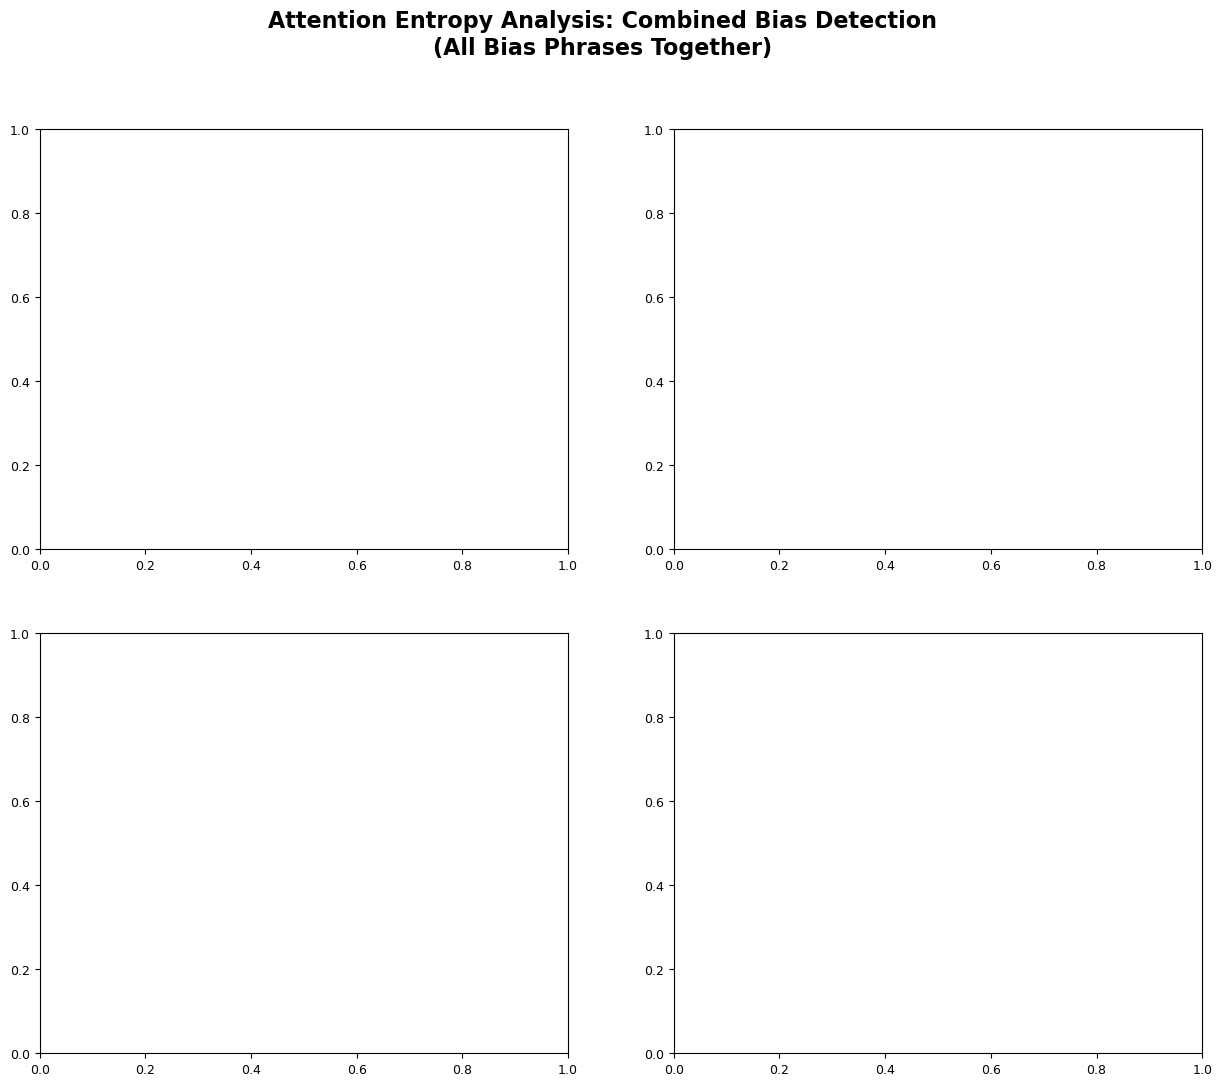

In [ ]:
class ResultsVisualizationIndividual:
    def __init__(self, aggregated_analysis_dir: str, statistical_results_dir: str,
                 entropy_results_dir: str):
        """
        Visualize Results: Create 7 separate visualization files (1 combined + 6 individual phrases)

        Each plot follows paste5.txt structure with 2×2 layout:
        - Histogram: Global entropy distributions vs baseline (no hint)
        - Line: Avg entropy vs layers (per variant)
        - Bar: Avg phrase entropy (baseline, prompt_1, prompt_2, prompt_3)
        - Heatmap: ΔH per layer/head

        Args:
            aggregated_analysis_dir: Directory containing individual phrase aggregation results
            statistical_results_dir: Directory containing individual phrase statistical analysis results
        """
        self.aggregated_analysis_dir = aggregated_analysis_dir
        self.statistical_results_dir = statistical_results_dir
        self.entropy_results_dir = entropy_results_dir

        print("Starting Individual Phrase Results Visualization")
        print("=" * 60)

        # Define analysis keys (6 individual + 1 combined)
        self.analysis_keys = ["teacher", "own", "sure", "unsure", "quick", "fast", "step", "combined"]
        self.individual_phrases = ["teacher", "own", "sure", "unsure", "quick", "fast", "step"]

        # Load data from previous stages
        self.load_visualization_data()

        # Set up plotting style
        self.setup_plotting_style()

    def setup_plotting_style(self):
        """Set up matplotlib and seaborn styling for publication-ready plots"""
        plt.style.use('default')
        sns.set_palette("husl")

        # Publication-ready settings
        plt.rcParams.update({
            'figure.figsize': (15, 12),
            'font.size': 10,
            'axes.titlesize': 12,
            'axes.labelsize': 11,
            'xtick.labelsize': 9,
            'ytick.labelsize': 9,
            'legend.fontsize': 9,
            'figure.titlesize': 14
        })

    def load_visualization_data(self):
        import os
        import json
        import re
        import numpy as np

        for phrase in self.analysis_keys:
            # Load aggregated entropies
            agg_file = os.path.join(self.aggregated_analysis_dir, f"aggregated_entropies_{phrase}.json")
            if os.path.exists(agg_file):
                with open(agg_file, 'r') as f:
                    self.aggregated_entropies_individual[phrase] = json.load(f)
            else:
                print(f"Warning: Aggregated entropies file not found: {agg_file}")

            # Load ΔH changes
            delta_file = os.path.join(self.aggregated_analysis_dir, f"delta_h_changes_{phrase}.json")
            if os.path.exists(delta_file):
                with open(delta_file, 'r') as f:
                    self.delta_h_changes_individual[phrase] = json.load(f)
            else:
                print(f"Warning: Delta H changes file not found: {delta_file}")

        # Load entropy arrays from subdirectories
        self.entropies_arrays = {}
        subdirs = [d for d in os.listdir(self.entropy_results_dir) if d.startswith('entropy_results_individual_')]
        
        for subdir in subdirs:
            match = re.match(r'entropy_results_individual_(\d+)_(\d+)', subdir)
            if match:
                start_row, end_row = map(int, match.groups())
                json_path = os.path.join(self.entropy_results_dir, subdir, "entropies_arrays.json")
                adjusted_json_path = os.path.join(self.entropy_results_dir, subdir, "adjusted_entropies_arrays.json")
                
                if os.path.exists(adjusted_json_path):
                    with open(adjusted_json_path, 'r') as f:
                        adjusted_data = json.load(f)
                    self.entropies_arrays.update(adjusted_data)
                    print(f"Loaded precomputed adjusted data from {adjusted_json_path}")
                    del adjusted_data  # Free memory
                elif os.path.exists(json_path):
                    print(f"Warning: Precomputed {adjusted_json_path} not found, computing from {json_path}")
                    with open(json_path, 'r') as f:
                        data = json.load(f)
                    
                    adjusted_data = {}
                    for key, value in data.items():
                        row_match = re.match(r'row_(\d+)_prompt_(\d+)', key)
                        if row_match:
                            row_num, prompt_num = map(int, row_match.groups())
                            adjusted_row_num = row_num + start_row
                            adjusted_key = f'row_{adjusted_row_num}_prompt_{prompt_num}'
                            adjusted_data[adjusted_key] = value
                        else:
                            print(f"Warning: Invalid key format in {json_path}: {key}")
                    
                    with open(adjusted_json_path, 'w') as f:
                        json.dump(adjusted_data, f)
                    print(f"Saved adjusted data to {adjusted_json_path}")
                    
                    self.entropies_arrays.update(adjusted_data)
                    del data, adjusted_data  # Free memory
                else:
                    print(f"Warning: entropies_arrays.json not found at {json_path}")
            else:
                print(f"Warning: Invalid subdirectory name format: {subdir}")

        print(f"Loaded visualization data for {len(self.aggregated_entropies_individual)} phrase analyses")
        print(f"Loaded entropy arrays for {len(self.entropies_arrays)} row-prompt combinations")

    def _compute_prompt_data_stats(self, phrase: str):
        """Compute prompt data statistics (values, averages, and standard deviations) for a given phrase."""
        import numpy as np
        import os
        import json

        # Define save paths
        prompt_data_file = os.path.join(self.entropy_results_dir, f"prompt_data_{phrase}.json")
        avg_entropies_file = os.path.join(self.entropy_results_dir, f"avg_entropies_{phrase}.npy")
        std_entropies_file = os.path.join(self.entropy_results_dir, f"std_entropies_{phrase}.npy")

        # Load from disk if available
        if (os.path.exists(prompt_data_file) and 
            os.path.exists(avg_entropies_file) and 
            os.path.exists(std_entropies_file)):
            with open(prompt_data_file, 'r') as f:
                prompt_data = json.load(f)
            avg_entropies = np.load(avg_entropies_file).tolist()
            std_entropies = np.load(std_entropies_file).tolist()
            print(f"Loaded prompt data and stats from disk for {phrase}")
            return prompt_data, avg_entropies, std_entropies

        # Initialize prompt data
        prompt_data = {'prompt_1': [], 'prompt_2': [], 'prompt_3': []}

        # Handle "combined" case or specific phrase
        if phrase == "combined":
            # Aggregate across all phrases in aggregated_entropies_individual
            for phrase_key, entropy_dict in self.aggregated_entropies_individual.items():
                for key, entropy_value in entropy_dict.items():
                    if entropy_value is not None:
                        for prompt_type in prompt_data.keys():
                            if prompt_type in key:
                                prompt_data[prompt_type].append(entropy_value)
                del entropy_dict  # Free memory per phrase
        else:
            # Specific phrase
            if phrase in self.aggregated_entropies_individual:
                for key, entropy_value in self.aggregated_entropies_individual[phrase].items():
                    if entropy_value is not None:
                        for prompt_type in prompt_data.keys():
                            if prompt_type in key:
                                prompt_data[prompt_type].append(entropy_value)
            else:
                print(f"Warning: Phrase '{phrase}' not found in aggregated_entropies_individual")

        # Calculate averages and standard deviations
        avg_entropies = []
        std_entropies = []
        for values in prompt_data.values():
            if values:
                avg_entropies.append(np.mean(values))
                std_entropies.append(np.std(values))
            else:
                avg_entropies.append(0)
                std_entropies.append(0)

        # Save to disk
        with open(prompt_data_file, 'w') as f:
            json.dump(prompt_data, f)
        np.save(avg_entropies_file, np.array(avg_entropies))
        np.save(std_entropies_file, np.array(std_entropies))
        print(f"Saved prompt data and stats to disk for {phrase}")

        return prompt_data, avg_entropies, std_entropies

    def create_bar_chart_phrase_entropy(self, ax, phrase: str):
        """Bar: Avg phrase entropy (baseline, prompt_1, prompt_2, prompt_3)"""
        print(f"Creating bar chart for {phrase}: Avg phrase entropy by variant...")
        import numpy as np
        import os
        import json

        # Get prompt data and precomputed statistics
        prompt_data, avg_entropies, std_entropies = self._compute_prompt_data_stats(phrase)

        # Calculate baseline entropy
        baseline_file = os.path.join(self.entropy_results_dir, f"baseline_entropies_bar_{phrase}.npy")
        if os.path.exists(baseline_file):
            baseline_entropy = np.load(baseline_file).tolist()
            print(f"Loaded baseline entropies from {baseline_file}")
        else:
            baseline_entropy = []
            subdirs = [d for d in os.listdir(self.entropy_results_dir) if d.startswith('entropy_results_individual_')]
            for subdir in subdirs:
                json_path = os.path.join(self.entropy_results_dir, subdir, "adjusted_entropies_arrays.json")
                if os.path.exists(json_path):
                    with open(json_path, 'r') as f:
                        data = json.load(f)
                    for row_prompt_key, entropy_array in data.items():
                        if 'prompt_1' in row_prompt_key:
                            parts = row_prompt_key.split('_')
                            if len(parts) == 4 and parts[0] == 'row' and parts[2] == 'prompt' and parts[3] == '1':
                                entropies = np.array(entropy_array)
                                global_entropy = np.mean(entropies)
                                baseline_entropy.append(global_entropy)
                                del entropies  # Free memory
                            else:
                                print(f"Warning: Invalid key format skipped in {subdir}: {row_prompt_key}")
                    del data  # Free memory
                else:
                    print(f"Warning: adjusted_entropies_arrays.json not found at {json_path}")
            if baseline_entropy:
                np.save(baseline_file, np.array(baseline_entropy))
                print(f"Saved baseline entropies to {baseline_file}")

        # Insert baseline stats at the beginning
        if baseline_entropy:
            avg_entropies.insert(0, np.mean(baseline_entropy))
            std_entropies.insert(0, np.std(baseline_entropy))
        else:
            avg_entropies.insert(0, 0)
            std_entropies.insert(0, 0)

        # Create bar chart
        labels = ['Baseline (No Hint)', 'Biased: Prompt 1', 'Biased: Prompt 2', 'Biased: Prompt 3']
        x = np.arange(len(labels))
        ax.bar(x, avg_entropies, yerr=std_entropies, capsize=5, color=['#808080', '#1f77b4', '#ff7f0e', '#2ca02c'],
            edgecolor='black', linewidth=0.5)

        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=45)
        ax.set_ylabel('Average Entropy (bits)')
        if phrase == 'combined':
            ax.set_title('Average Phrase Entropy by Prompt Variant\n(All Bias Phrases)')
        else:
            ax.set_title(f'Average Phrase Entropy by Prompt Variant\n(Phrase: "{phrase}")')
        ax.grid(True, axis='y', alpha=0.3)

        # Add value labels on top of bars
        for i, v in enumerate(avg_entropies):
            if v != 0:
                ax.text(i, v + 0.01 * max(avg_entropies), f'{v:.3f}', ha='center', va='bottom', fontsize=8)

    def create_histogram_phrase_entropy(self, ax, phrase: str):
        """Histogram: Phrase entropy distributions vs baseline (no hint)"""
        print(f"Creating histogram for {phrase}: Phrase entropy distributions vs baseline...")
        import numpy as np
        import os
        import json

        # Get prompt data and precomputed statistics
        prompt_data, _, _ = self._compute_prompt_data_stats(phrase)
        print(f"Available keys for {phrase}: {list(self.aggregated_entropies_individual[phrase].keys())}")

        # Get baseline entropies
        baseline_file = os.path.join(self.entropy_results_dir, f"baseline_entropies_histogram_{phrase}.npy")
        if os.path.exists(baseline_file):
            baseline_entropies = np.load(baseline_file).tolist()
            print(f"Loaded baseline entropies from {baseline_file}")
        else:
            baseline_entropies = []
            subdirs = [d for d in os.listdir(self.entropy_results_dir) if d.startswith('entropy_results_individual_')]
            for subdir in subdirs:
                json_path = os.path.join(self.entropy_results_dir, subdir, "adjusted_entropies_arrays.json")
                if os.path.exists(json_path):
                    with open(json_path, 'r') as f:
                        data = json.load(f)
                    all_keys = list(data.keys())
                    baseline_rows_local = set()

                    for key in all_keys:
                        if 'prompt_1' in key:
                            parts = key.split('_')
                            if len(parts) == 4 and parts[0] == 'row' and parts[2] == 'prompt' and parts[3] == '1':
                                row_num = parts[1]
                                has_prompt_2 = any(f'row_{row_num}_prompt_2' in k for k in all_keys)
                                has_prompt_3 = any(f'row_{row_num}_prompt_3' in k for k in all_keys)
                                if not has_prompt_2 and not has_prompt_3:
                                    baseline_rows_local.add(row_num)

                    for row_prompt_key, entropy_array in data.items():
                        if 'prompt_1' in row_prompt_key:
                            parts = row_prompt_key.split('_')
                            if len(parts) == 4 and parts[0] == 'row' and parts[2] == 'prompt' and parts[3] == '1':
                                row_num = parts[1]
                                if row_num in baseline_rows_local:
                                    entropies = np.array(entropy_array)
                                    global_entropy = np.mean(entropies)
                                    baseline_entropies.append(global_entropy)
                                    del entropies  # Free memory
                            else:
                                print(f"Warning: Invalid key format skipped: {row_prompt_key}")
                    del data  # Free memory
                else:
                    print(f"Warning: adjusted_entropies_arrays.json not found at {json_path}")
            if baseline_entropies:
                np.save(baseline_file, np.array(baseline_entropies))
                print(f"Saved baseline entropies to {baseline_file}")

        # Create histogram
        colors = ['#808080', '#1f77b4', '#ff7f0e', '#2ca02c']
        labels = ['Baseline (No Hint)', 'Biased: Prompt 1', 'Biased: Prompt 2', 'Biased: Prompt 3']

        all_values = []
        for values in prompt_data.values():
            if values:
                all_values.extend(values)
        if baseline_entropies:
            all_values.extend(baseline_entropies)

        if all_values:
            bins = np.linspace(min(all_values), max(all_values), 15)

            if baseline_entropies:
                ax.hist(baseline_entropies, bins=bins, alpha=0.7, label=labels[0],
                    color=colors[0], edgecolor='black', linewidth=0.5)

            for i, (prompt_type, values) in enumerate(prompt_data.items(), 1):
                if values:
                    ax.hist(values, bins=bins, alpha=0.7, label=labels[i],
                        color=colors[i], edgecolor='black', linewidth=0.5)

        ax.set_xlabel('Entropy (bits)')
        ax.set_ylabel('Frequency')
        if phrase == 'combined':
            ax.set_title('Global Entropy Distributions vs Baseline\n(All Bias Phrases)')
        else:
            ax.set_title(f'Entropy Distributions vs Baseline\n(Phrase: "{phrase}")')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Add summary statistics
        stats_text = []
        if baseline_entropies:
            stats_text.append(f"Baseline: μ={np.mean(baseline_entropies):.3f}")
        for prompt_type, values in prompt_data.items():
            if values:
                mean_val = np.mean(values)
                stats_text.append(f"{prompt_type}: μ={mean_val:.3f}")

        if stats_text:
            ax.text(0.02, 0.98, '\n'.join(stats_text), transform=ax.transAxes,
                    verticalalignment='top', fontsize=8,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
   
    def create_line_plot_entropy_vs_layers(self, ax, phrase: str):
        """Line: Avg entropy vs layers (per variant)"""
        print(f"Creating line plot for {phrase}: Avg entropy vs layers...")
        import numpy as np

        # Compute layer-wise entropy data
        layer_data = self._compute_layer_data(phrase)

        # Calculate averages and plot
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        labels = ['Biased: Prompt 1', 'Biased: Prompt 2', 'Biased: Prompt 3']
        linestyles = ['-', '--', '-.']

        for i, (prompt_type, data) in enumerate(layer_data.items()):
            if data:
                layers = sorted(data.keys())
                avg_entropies = [np.mean(data[layer]) for layer in layers]
                std_entropies = [np.std(data[layer]) for layer in layers]

                if avg_entropies:
                    # Plot line with error bars
                    ax.plot(layers, avg_entropies, color=colors[i], label=labels[i],
                        linewidth=2, linestyle=linestyles[i], marker='o', markersize=4)

                    # Add error bands
                    ax.fill_between(layers,
                                [avg - std for avg, std in zip(avg_entropies, std_entropies)],
                                [avg + std for avg, std in zip(avg_entropies, std_entropies)],
                                alpha=0.2, color=colors[i])

        ax.set_xlabel('Layer Index')
        ax.set_ylabel('Average Entropy (bits)')
        if phrase == 'combined':
            ax.set_title('Average Entropy vs Layers\n(All Bias Phrases)')
        else:
            ax.set_title(f'Average Entropy vs Layers\n(Phrase: "{phrase}")')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Highlight mid-layers if we have layer data
        if any(layer_data.values()):
            max_layers = max(max(data.keys()) if data else [0] for data in layer_data.values())
            if max_layers > 0:
                mid_start = max_layers // 3
                mid_end = 2 * max_layers // 3
                ax.axvspan(mid_start, mid_end, alpha=0.1, color='red', label='Mid-layers')
                ax.legend()  # Update legend to include mid-layers

    def _compute_layer_data(self, phrase: str):
        import numpy as np
        import os
        import json
        import re

        layer_data_file = os.path.join(self.entropy_results_dir, f"layer_data_{phrase}.json")
        positions_file_saved = os.path.join(self.entropy_results_dir, f"phrase_positions_merged_{phrase}.json")

        if os.path.exists(layer_data_file) and os.path.exists(positions_file_saved):
            with open(layer_data_file, 'r') as f:
                layer_data = json.load(f)
            with open(positions_file_saved, 'r') as f:
                phrase_positions_by_row_prompt = json.load(f)
            print(f"Loaded layer data and positions from disk for {phrase}")
            return layer_data, phrase_positions_by_row_prompt

        layer_data = {'prompt_1': {}, 'prompt_2': {}, 'prompt_3': {}}
        phrase_positions_by_row_prompt = {}
        subdirs = [d for d in os.listdir(self.entropy_results_dir) if d.startswith('entropy_results_individual_')]
        for subdir in subdirs:
            positions_file = os.path.join(self.entropy_results_dir, subdir, f"hint_positions_{phrase}.json")
            if os.path.exists(positions_file):
                with open(positions_file, 'r') as f:
                    phrase_positions_data = json.load(f)

                match = re.match(r'entropy_results_individual_(\d+)_(\d+)', subdir)
                if match:
                    start_row = int(match.group(1))
                    for key, positions in phrase_positions_data.items():
                        parts = key.split('_')
                        if len(parts) >= 3 and parts[0].isdigit() and parts[1] == 'prompt':
                            row_idx = int(parts[0]) + start_row
                            prompt_num = parts[2]
                            row_prompt_key = f"row_{row_idx}_prompt_{prompt_num}"
                            phrase_positions_by_row_prompt[row_prompt_key] = positions
                        else:
                            print(f"Warning: Invalid key format in {positions_file}: {key}")
                else:
                    print(f"Warning: Invalid subdirectory name: {subdir}")
                del phrase_positions_data  # Free memory
            else:
                print(f"Warning: Phrase positions file not found: {positions_file}")

        if hasattr(self, 'entropies_arrays') and phrase_positions_by_row_prompt:
            for row_prompt_key, entropy_array in self.entropies_arrays.items():
                parts = row_prompt_key.split('_')
                if len(parts) == 4 and parts[0] == 'row' and parts[2] == 'prompt':
                    prompt_num = parts[3]
                    if row_prompt_key in phrase_positions_by_row_prompt:
                        positions = phrase_positions_by_row_prompt[row_prompt_key]
                        if positions:
                            entropies = np.array(entropy_array)
                            num_layers, num_heads, seq_len = entropies.shape

                            for layer_idx in range(num_layers):
                                layer_phrase_entropies = []
                                for head_idx in range(num_heads):
                                    for pos in positions:
                                        if pos < seq_len:
                                            layer_phrase_entropies.append(entropies[layer_idx, head_idx, pos])

                                if layer_phrase_entropies:
                                    if layer_idx not in layer_data[f'prompt_{prompt_num}']:
                                        layer_data[f'prompt_{prompt_num}'][layer_idx] = []
                                    layer_data[f'prompt_{prompt_num}'][layer_idx].extend(layer_phrase_entropies)
                            del entropies  # Free memory
                else:
                    print(f"Warning: Invalid key format skipped in entropies_arrays: {row_prompt_key}")

        with open(layer_data_file, 'w') as f:
            json.dump(layer_data, f)
        with open(positions_file_saved, 'w') as f:
            json.dump(phrase_positions_by_row_prompt, f)
        print(f"Saved layer data and positions to disk for {phrase}")

        return layer_data, phrase_positions_by_row_prompt

    def _compute_delta_h_matrix(self, phrase: str, num_layers: int = 16, num_heads: int = 32):
        import numpy as np

        matrix_file = os.path.join(self.entropy_results_dir, f"delta_h_matrix_{phrase}.npy")
        counts_file = os.path.join(self.entropy_results_dir, f"layer_counts_{phrase}.npy")

        if os.path.exists(matrix_file) and os.path.exists(counts_file):
            delta_h_matrix = np.load(matrix_file)
            layer_counts = np.load(counts_file)
            print(f"Loaded delta_h_matrix and layer_counts from disk for {phrase}")
            return delta_h_matrix, layer_counts

        delta_h_matrix = np.zeros((num_layers, num_heads))
        layer_counts = np.zeros((num_layers, num_heads))

        layer_data, phrase_positions_by_row_prompt = self._compute_layer_data(phrase)

        if layer_data and phrase_positions_by_row_prompt:
            row_entropy_data = {}
            for row_prompt_key, entropy_array in self.entropies_arrays.items():
                if row_prompt_key in phrase_positions_by_row_prompt:
                    positions = phrase_positions_by_row_prompt[row_prompt_key]
                    if positions:
                        parts = row_prompt_key.split('_')
                        if len(parts) == 4 and parts[0] == 'row' and parts[2] == 'prompt':
                            row_idx = int(parts[1])
                            prompt_num = int(parts[3])

                            if row_idx not in row_entropy_data:
                                row_entropy_data[row_idx] = {}

                            entropies = np.array(entropy_array)
                            actual_layers, actual_heads, seq_len = entropies.shape

                            prompt_layer_head_data = {}
                            for layer_idx in range(min(actual_layers, num_layers)):
                                prompt_layer_head_data[layer_idx] = {}
                                for head_idx in range(min(actual_heads, num_heads)):
                                    phrase_entropies = []
                                    for pos in positions:
                                        if pos < seq_len:
                                            phrase_entropies.append(entropies[layer_idx, head_idx, pos])
                                    if phrase_entropies:
                                        prompt_layer_head_data[layer_idx][head_idx] = np.mean(phrase_entropies)
                            row_entropy_data[row_idx][prompt_num] = prompt_layer_head_data
                            del entropies, prompt_layer_head_data  # Free memory
                        else:
                            print(f"Warning: Invalid key format skipped: {row_prompt_key}")

            for row_idx, prompt_data in row_entropy_data.items():
                for baseline_prompt, variant_prompt in [(1, 2), (1, 3)]:
                    if baseline_prompt in prompt_data and variant_prompt in prompt_data:
                        baseline_data = prompt_data[baseline_prompt]
                        variant_data = prompt_data[variant_prompt]

                        for layer_idx in range(num_layers):
                            if layer_idx in baseline_data and layer_idx in variant_data:
                                for head_idx in range(num_heads):
                                    if (head_idx in baseline_data[layer_idx] and
                                        head_idx in variant_data[layer_idx]):
                                        baseline_entropy = baseline_data[layer_idx][head_idx]
                                        variant_entropy = variant_data[layer_idx][head_idx]
                                        delta_h = baseline_entropy - variant_entropy

                                        delta_h_matrix[layer_idx, head_idx] += delta_h
                                        layer_counts[layer_idx, head_idx] += 1
                del row_entropy_data[row_idx]  # Free memory per row

        mask = layer_counts == 0
        if not mask.all():
            delta_h_matrix[~mask] = delta_h_matrix[~mask] / layer_counts[~mask]

        if mask.all() and phrase in self.delta_h_changes_individual:
            all_delta_h = []
            for row_changes in self.delta_h_changes_individual[phrase].values():
                all_delta_h.extend(row_changes.values())

            if all_delta_h:
                avg_delta_h = np.mean(all_delta_h)
                std_delta_h = np.std(all_delta_h)

                for layer_idx in range(num_layers):
                    layer_weight = 1.0
                    if 5 <= layer_idx <= 10:
                        layer_weight = 1.5
                    elif layer_idx < 3 or layer_idx > 13:
                        layer_weight = 0.7

                    for head_idx in range(num_heads):
                        head_variation = np.random.normal(0, std_delta_h * 0.2)
                        delta_h_matrix[layer_idx, head_idx] = avg_delta_h * layer_weight + head_variation
                        layer_counts[layer_idx, head_idx] = len(all_delta_h)

        np.save(matrix_file, delta_h_matrix)
        np.save(counts_file, layer_counts)
        print(f"Saved delta_h_matrix and layer_counts to disk for {phrase}")

        return delta_h_matrix, layer_counts

    def create_heatmap_delta_h(self, ax, phrase: str):
        """Heatmap: ΔH per layer/head for this phrase"""
        print(f"Creating heatmap for {phrase}: Computing layer-wise ΔH...")
        import numpy as np
        import matplotlib.pyplot as plt

        # Compute ΔH matrix
        num_layers, num_heads = 16, 32
        delta_h_matrix, layer_counts = self._compute_delta_h_matrix(phrase, num_layers, num_heads)

        # Add noise to show patterns if values are too uniform
        mask = layer_counts == 0
        if not mask.all():
            non_zero_values = delta_h_matrix[~mask]
            if len(non_zero_values) > 0 and np.std(non_zero_values) < 0.001:
                noise = np.random.normal(0, np.abs(np.mean(non_zero_values)) * 0.1, delta_h_matrix.shape)
                delta_h_matrix[~mask] += noise[~mask]

        # Create heatmap
        if not mask.all():
            vmax = max(0.001, np.abs(delta_h_matrix[~mask]).max())
        else:
            vmax = 0.001

        im = ax.imshow(delta_h_matrix, cmap='RdBu_r', aspect='auto', vmin=-vmax, vmax=vmax)
        ax.invert_yaxis()

        # Customize heatmap
        ax.set_xlabel('Attention Head')
        ax.set_ylabel('Layer')
        if phrase == 'combined':
            ax.set_title('ΔH per Layer/Head\n(All Bias Phrases)\n(Red: More Focused, Blue: Less Focused)')
        else:
            ax.set_title(f'ΔH per Layer/Head\n(Phrase: "{phrase}")\n(Red: More Focused, Blue: Less Focused)')

        # Set ticks
        ax.set_xticks(range(0, num_heads, 4))
        ax.set_xticklabels(range(0, num_heads, 4))
        ax.set_yticks(range(num_layers))
        ax.set_yticklabels(range(num_layers))

        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('ΔH (H_baseline - H_variant)', rotation=270, labelpad=15)

        # Add text annotations for significant values
        if not mask.all():
            for i in range(0, num_layers, 3):
                for j in range(0, num_heads, 8):
                    if not mask[i, j] and abs(delta_h_matrix[i, j]) > vmax * 0.3:
                        ax.text(j, i, f'{delta_h_matrix[i, j]:.3f}',
                            ha='center', va='center', fontsize=6,
                            color='white' if abs(delta_h_matrix[i, j]) > vmax * 0.7 else 'black')

        # Add statistics box
        if not mask.all():
            stats_text = f'Mean ΔH: {np.mean(delta_h_matrix[~mask]):.4f}\nStd ΔH: {np.std(delta_h_matrix[~mask]):.4f}'
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
                    verticalalignment='top', fontsize=8,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        

    def create_individual_phrase_plot(self, phrase: str, save_path: str):
        """Create individual phrase visualization (2x2 layout like paste5.txt)"""
        print(f"Creating individual visualization for phrase: {phrase}")

        # Create figure and subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

        if phrase == 'combined':
            fig.suptitle('Attention Entropy Analysis: Combined Bias Detection\n(All Bias Phrases Together)',
                        fontsize=16, fontweight='bold', y=0.98)
        else:
            fig.suptitle(f'Attention Entropy Analysis: Individual Phrase Bias Detection\nPhrase: "{phrase}"',
                        fontsize=16, fontweight='bold', y=0.98)

        # Top Left: Histogram - Phrase entropy distributions vs baseline
        self.create_histogram_phrase_entropy(ax1, phrase)

        # Top Right: Line Plot - Avg entropy vs layers
        self.create_line_plot_entropy_vs_layers(ax2, phrase)

        # Bottom Left: Bar Chart - Avg phrase entropy by variant
        self.create_bar_chart_phrase_entropy(ax3, phrase)

        # Bottom Right: Heatmap - ΔH per layer/head
        self.create_heatmap_delta_h(ax4, phrase)

        # Adjust layout
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Save the plot
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Saved {phrase} plot: {save_path}")
        plt.close()

        return save_path

    def run_complete_visualization(self, output_dir: str = VISUAL_RESULTS_DIR):
        """Run the complete individual phrase visualization pipeline - 7 separate PNG files"""
        print("Running complete individual phrase visualization pipeline...")
        print("Generating 7 separate PNG files (1 combined + 6 individual phrases)")

        os.makedirs(output_dir, exist_ok=True)

        generated_files = []

        # 1. Create combined analysis plot
        combined_path = os.path.join(output_dir, "combined_bias_analysis.png")
        combined_file = self.create_individual_phrase_plot("combined", combined_path)
        generated_files.append(combined_file)

        # 2. Create individual phrase plots
        for phrase in self.individual_phrases:
            phrase_path = os.path.join(output_dir, f"{phrase}_bias_analysis.png")
            phrase_file = self.create_individual_phrase_plot(phrase, phrase_path)
            generated_files.append(phrase_file)

        # Save metadata about the visualizations
        viz_metadata = {
            'visualization_structure': {
                'total_files': 7,
                'combined_analysis': 'combined_bias_analysis.png',
                'individual_phrase_files': [f"{phrase}_bias_analysis.png" for phrase in self.individual_phrases]
            },
            'plot_layout': '2x2 subplots per file (following paste5.txt structure)',
            'plot_descriptions': {
                'top_left': 'Histogram: Phrase entropy distributions vs baseline (no hint)',
                'top_right': 'Line plot: Average entropy vs layers (per variant)',
                'bottom_left': 'Bar chart: Average phrase entropy (baseline + 3 biased variants)',
                'bottom_right': 'Heatmap: ΔH per layer/head (bias effects)'
            },
            'analysis_structure': {
                'individual_phrases': self.individual_phrases,
                'combined_analysis': 'All bias phrases together',
                'baseline_comparison': 'Baseline = no hint phrases (global entropy)'
            },
            'interpretation': {
                'baseline_vs_biased': 'Baseline shows attention without bias phrases',
                'negative_delta_h': 'More focused attention at phrase positions (unfaithful)',
                'positive_delta_h': 'Less focused attention at phrase positions (faithful)',
                'high_entropy': 'Balanced/faithful attention',
                'low_entropy': 'Focused/potentially unfaithful attention'
            },
            'files_generated': generated_files
        }

        metadata_file = os.path.join(output_dir, "visualization_metadata.json")
        with open(metadata_file, 'w') as f:
            json.dump(viz_metadata, f, indent=2)

        print("\nIndividual phrase results visualization completed successfully!")
        print(f"Generated {len(generated_files)} visualization files:")
        for i, file_path in enumerate(generated_files, 1):
            file_name = os.path.basename(file_path)
            if 'combined' in file_name:
                print(f"  {i}. {file_name} (All bias phrases together)")
            else:
                phrase = file_name.replace('_bias_analysis.png', '')
                print(f"  {i}. {file_name} (Individual phrase: '{phrase}')")

        print(f"\nAll visualizations saved to: {output_dir}/")
        print("Complete individual phrase attention entropy analysis pipeline finished!")

        return output_dir, generated_files


def run_results_visualization_individual():
    """
    Run the complete individual phrase results visualization pipeline
    """
    # Configuration - Update these paths for your setup

    print("Starting Individual Phrase Results Visualization")
    print("=" * 60)

    # Initialize visualizer
    visualizer = ResultsVisualizationIndividual(
        aggregated_analysis_dir=AGGREGATED_ANALYSIS_DIR,
        statistical_results_dir=STATISTICAL_RESULTS_DIR,
        entropy_results_dir=ENTROPY_RESULTS_DIR
    )

    # Run complete visualization
    output_dir, generated_files = visualizer.run_complete_visualization()

    print(f"\nIndividual phrase results visualization completed: {output_dir}")
    print("Pipeline: Data preparation → Entropy computation → Aggregation → Statistical analysis → Visualization")
    print(f"Analyzed phrases: combined + {', '.join(visualizer.individual_phrases)}")

    return visualizer, generated_files


if __name__ == "__main__":
    visualizer, generated_files = run_results_visualization_individual()
    print(f"\nGenerated visualization files: {len(generated_files)}")
    for file_path in generated_files:
        print(f"  - {os.path.basename(file_path)}")